# Natural Language Processing analysis of Mastodon's servers' rules

In [216]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [217]:
import pandas as pd
import numpy as np

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Natural language processing
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

# Topic modeling with BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from hdbscan import HDBSCAN
from umap import UMAP

# Fixing random components
import random
seed = random.seed(1)

from utils.SocialMediaDataset import MastodonDataset, RedditDataset
import utils.utils as utils

## Data cleaning and preprocessing

In [218]:
mastodon = MastodonDataset()
reddit = RedditDataset()

In [219]:
mastodon.df

,domain,title,description,active_month,languages,rules,total_users,server_id
0,mastodon.social,Mastodon,The original server operated by the Mastodon g...,327503,"[""en""]","[{""id"": ""1"", ""text"": ""Sexually explicit or vio...",2711879.0,0
1,mstdn.social,Mastodon 🐘,A general-purpose Mastodon server with a 500 c...,14546,"[""en""]","[{""id"": ""2"", ""text"": ""Sexually explicit or vio...",260323.0,1
2,infosec.exchange,Infosec Exchange,A Mastodon instance for info/cyber security-mi...,13319,"[""en""]","[{""id"": ""1"", ""text"": ""Do unto others as you th...",75725.0,2
3,mas.to,mas.to,"Hello! mas.to is a fast, up-to-date and fun Ma...",11889,"[""en""]","[{""id"": ""9"", ""text"": ""No discrimination, inclu...",183608.0,3
4,mastodon.world,Mastodon,Generic Mastodon server for anyone to use.,9472,"[""en""]","[{""id"": ""16"", ""text"": ""No illegal content, e.g...",191710.0,4
...,...,...,...,...,...,...,...,...
325,mikumikudance.cloud,MikuMikuDance.Cloud,MikuMikuDanceで動画や静画を製作しているMMDerさん、MMDの鑑賞が好きな視聴...,3,"[""ja""]","[{""id"": ""1"", ""text"": ""日本国内の法律及び各自治体の条例を守ってください...",605.0,325
326,kjas.no,Mastodon | Kjas.no,Server for brukere med litt ekstra interesse f...,3,"[""en""]","[{""id"": ""1"", ""text"": ""Vær ålreit med hverandre...",24.0,326
327,jaxbeach.social,JaxBeach Social,Local server based in Jacksonville Beach Flori...,3,"[""en""]","[{""id"": ""1"", ""text"": ""No Illegal content"", ""hi...",17.0,327
328,troet.fediverse.at,Fediverse Austria,Die Instanz für engagierte Menschen und kritis...,3,"[""de""]","[{""id"": ""3"", ""text"": ""Schreibe unter deinem ec...",30.0,328


In [220]:
reddit.df

,name,title,description,language,subscribers,active_user_count,rules,server_id
0,Home,Home,NaN,en,307843,51,NaN,0
1,AskReddit,Ask Reddit...,r/AskReddit is the place to ask and answer tho...,es,54701432,9986,Rule 1 - Questions must be clear and direct an...,1
2,NoStupidQuestions,No such thing as stupid questions,Ask away!\n\nDisclaimer: This is an anonymous ...,en,6021303,4872,Top level comments must contain a genuine huma...,2
3,BaldursGate3,Baldur's Gate 3,"A community all about Baldur's Gate III, the r...",en,3118378,1384,Be civil to one another.; Respect the opinions...,3
4,facepalm,now double verified,/r/facepalm - please sir can I have some more?,en,8145733,2345,"No uncivil, bigoted, misogynist, misandrist, r...",4
...,...,...,...,...,...,...,...,...
95,SteamDeck,Steam Deck,The Unofficial Subreddit for the Valve Steam D...,en,903284,446,Be Kind Or Get Banned; Posts must be about or ...,95
96,college,College,The subreddit for discussion related to colleg...,en,2911405,76,Do not post spam or surveys.; Do not post anyt...,96
97,manga,"/r/manga: manga, on reddit.",Everything and anything manga! (manhwa/manhua...,en,4725267,1480,Disrespectful; Follow submission guidelines wh...,97
98,CrazyFuckingVideos,CrazyFuckingVideos,Crazy fucking videos for your viewing pleasure,en,2240152,799,Follow Reddit's TOS; Be civil; Must be a Crazy...,98


In [221]:
mastodon.clean()
reddit.clean()


Starting data cleaning process... 🧹🧼
Cleaning column: description
Cleaning column: active_month
Cleaning column: languages
Cleaning column: rules
Cleaning column: total_users
Data is all clean and shiny! ✨🫧

Starting data cleaning process... 🧹🧼
Cleaning column: description
Cleaning column: languages
Cleaning column: total_users
Cleaning column: active_month
Cleaning column: rules
Data is all clean and shiny! ✨🫧


In [222]:
df_mastodon = mastodon.df
df_mastodon

,domain,title,description,active_month,languages,rules,total_users,server_id
0,mastodon.social,Mastodon,The original server operated by the Mastodon g...,327503,[en],"[{'id': '1', 'text': 'Sexually explicit or vio...",2711879,0
1,mstdn.social,Mastodon 🐘,A general-purpose Mastodon server with a 500 c...,14546,[en],"[{'id': '2', 'text': 'Sexually explicit or vio...",260323,1
2,infosec.exchange,Infosec Exchange,A Mastodon instance for info/cyber security-mi...,13319,[en],"[{'id': '1', 'text': 'Do unto others as you th...",75725,2
3,mas.to,mas.to,"Hello! mas.to is a fast, up-to-date and fun Ma...",11889,[en],"[{'id': '9', 'text': 'No discrimination, inclu...",183608,3
4,mastodon.world,Mastodon,Generic Mastodon server for anyone to use.,9472,[en],"[{'id': '16', 'text': 'No illegal content, e.g...",191710,4
...,...,...,...,...,...,...,...,...
325,mikumikudance.cloud,MikuMikuDance.Cloud,MikuMikuDanceで動画や静画を製作しているMMDerさん、MMDの鑑賞が好きな視聴...,3,[ja],"[{'id': '1', 'text': '日本国内の法律及び各自治体の条例を守ってください...",605,325
326,kjas.no,Mastodon | Kjas.no,Server for brukere med litt ekstra interesse f...,3,[en],"[{'id': '1', 'text': 'Vær ålreit med hverandre...",24,326
327,jaxbeach.social,JaxBeach Social,Local server based in Jacksonville Beach Flori...,3,[en],"[{'id': '1', 'text': 'No Illegal content', 'hi...",17,327
328,troet.fediverse.at,Fediverse Austria,Die Instanz für engagierte Menschen und kritis...,3,[de],"[{'id': '3', 'text': 'Schreibe unter deinem ec...",30,328


In [223]:
df_reddit = reddit.df
df_reddit

,domain,title,description,languages,total_users,active_month,rules,server_id
0,Home,Home,nan,en,307843,51,[],0
1,AskReddit,Ask Reddit...,r/AskReddit is the place to ask and answer tho...,es,54701432,9986,[Rule 1 - Questions must be clear and direct a...,1
2,NoStupidQuestions,No such thing as stupid questions,Ask away!\n\nDisclaimer: This is an anonymous ...,en,6021303,4872,[Top level comments must contain a genuine hum...,2
3,BaldursGate3,Baldur's Gate 3,"A community all about Baldur's Gate III, the r...",en,3118378,1384,"[Be civil to one another., Respect the opinio...",3
4,facepalm,now double verified,/r/facepalm - please sir can I have some more?,en,8145733,2345,"[No uncivil, bigoted, misogynist, misandrist, ...",4
...,...,...,...,...,...,...,...,...
95,SteamDeck,Steam Deck,The Unofficial Subreddit for the Valve Steam D...,en,903284,446,"[Be Kind Or Get Banned, Posts must be about o...",95
96,college,College,The subreddit for discussion related to colleg...,en,2911405,76,"[Do not post spam or surveys., Do not post an...",96
97,manga,"/r/manga: manga, on reddit.",Everything and anything manga! (manhwa/manhua...,en,4725267,1480,"[Disrespectful, Follow submission guidelines ...",97
98,CrazyFuckingVideos,CrazyFuckingVideos,Crazy fucking videos for your viewing pleasure,en,2240152,799,"[Follow Reddit's TOS, Be civil, Must be a Cr...",98


In [224]:
display(utils.compare_languages(df_mastodon, df_reddit))

,mastodon,reddit
0,'en' : 234,'en' : 99
1,'de' : 33,'es' : 1
2,'fr' : 13,
3,'es' : 9,
4,'it' : 5,
5,'ko' : 5,
6,'nl' : 4,
7,'pt-BR' : 3,
8,'pl' : 2,
9,'et' : 2,


In [225]:
df_mastodon_en = mastodon.take_english_servers_only()
df_reddit_en =  reddit.take_english_servers_only()

In [229]:
df_mastodon_en

,domain,title,description,active_month,languages,rules,total_users,server_id
0,mastodon.social,Mastodon,The original server operated by the Mastodon g...,327503,[en],"[{'id': '1', 'text': 'Sexually explicit or vio...",2711879,0
1,mstdn.social,Mastodon 🐘,A general-purpose Mastodon server with a 500 c...,14546,[en],"[{'id': '2', 'text': 'Sexually explicit or vio...",260323,1
2,infosec.exchange,Infosec Exchange,A Mastodon instance for info/cyber security-mi...,13319,[en],"[{'id': '1', 'text': 'Do unto others as you th...",75725,2
3,mas.to,mas.to,"Hello! mas.to is a fast, up-to-date and fun Ma...",11889,[en],"[{'id': '9', 'text': 'No discrimination, inclu...",183608,3
4,mastodon.world,Mastodon,Generic Mastodon server for anyone to use.,9472,[en],"[{'id': '16', 'text': 'No illegal content, e.g...",191710,4
...,...,...,...,...,...,...,...,...
321,darticulate.com,Mastodon for Dartisans,"A Mastodon instance for Dartisans, run by myse...",10,[en],"[{'id': '2', 'text': 'This server is intended ...",43,321
322,dariox.club,DARiOX,A safe space for tech-centered LGBTQI+ folks a...,9,[en],"[{'id': '2', 'text': 'No illegal content', 'hi...",150,322
326,kjas.no,Mastodon | Kjas.no,Server for brukere med litt ekstra interesse f...,3,[en],"[{'id': '1', 'text': 'Vær ålreit med hverandre...",24,326
327,jaxbeach.social,JaxBeach Social,Local server based in Jacksonville Beach Flori...,3,[en],"[{'id': '1', 'text': 'No Illegal content', 'hi...",17,327


## Mastodon dataset

In [230]:
mastodon_rules = mastodon.extract_rules()
mastodon_rules

,server_id,rule_id,text,hint
0,0,1,Sexually explicit or violent media must be mar...,This includes content that is particularly pro...
1,0,2,"No racism, sexism, homophobia, transphobia, ab...",Transphobic behavior such as intentional misge...
2,0,3,No incitement of violence or promotion of viol...,Calling for people or groups to be assassinate...
3,0,4,"No harassment, block evasion, dogpiling, or do...",Repeat attempts to communicate with users who ...
4,0,7,Do not share information widely-known to be fa...,False and misleading information and links fro...
...,...,...,...,...
1912,329,77,③ 同意呜呜站的社区规则？/ Do you agree with the community...,
1913,329,78,🌸 缺项或错误将被拒绝 ... / Incomplete or nonsensical re...,
1914,329,79,"详细社区规则见： / For detailed community rules, pleas...",
1915,329,80,https://wxw.moe/about,


In [231]:
mastodon.predicts_english_rules()

,server_id,rule_id,text,hint,is_english_pred
0,0,1,Sexually explicit or violent media must be mar...,This includes content that is particularly pro...,True
1,0,2,"No racism, sexism, homophobia, transphobia, ab...",Transphobic behavior such as intentional misge...,True
2,0,3,No incitement of violence or promotion of viol...,Calling for people or groups to be assassinate...,True
3,0,4,"No harassment, block evasion, dogpiling, or do...",Repeat attempts to communicate with users who ...,True
4,0,7,Do not share information widely-known to be fa...,False and misleading information and links fro...,True
...,...,...,...,...,...
1912,329,77,③ 同意呜呜站的社区规则？/ Do you agree with the community...,,True
1913,329,78,🌸 缺项或错误将被拒绝 ... / Incomplete or nonsensical re...,,False
1914,329,79,"详细社区规则见： / For detailed community rules, pleas...",,False
1915,329,80,https://wxw.moe/about,,False


In [235]:
mastodon.rules_df

,server_id,rule_id,text,hint,is_english_pred
0,0,1,Sexually explicit or violent media must be mar...,This includes content that is particularly pro...,True
1,0,2,"No racism, sexism, homophobia, transphobia, ab...",Transphobic behavior such as intentional misge...,True
2,0,3,No incitement of violence or promotion of viol...,Calling for people or groups to be assassinate...,True
3,0,4,"No harassment, block evasion, dogpiling, or do...",Repeat attempts to communicate with users who ...,True
4,0,7,Do not share information widely-known to be fa...,False and misleading information and links fro...,True
...,...,...,...,...,...
1912,329,77,③ 同意呜呜站的社区规则？/ Do you agree with the community...,,True
1913,329,78,🌸 缺项或错误将被拒绝 ... / Incomplete or nonsensical re...,,False
1914,329,79,"详细社区规则见： / For detailed community rules, pleas...",,False
1915,329,80,https://wxw.moe/about,,False


In [ ]:
# server 100 : each rule is half english
# server 329: rules half in english
# -> cleaning required

# server 176: each rule  is also translated in english
# server 229: some rules are in english
# server 230: one rule in english
# server 292: half of rules in english
# -> take only english ones among them

In [236]:
blu = mastodon.rules_df.groupby("server_id")[["server_id", "is_english_pred"]].apply(lambda server: server["is_english_pred"].sum() / server["server_id"].count()).reset_index(name='is_english_pred_rate')

blu[blu["is_english_pred_rate"] != 1]

,server_id,is_english_pred_rate
5,6,0.692308
9,13,0.000000
11,15,0.900000
12,16,0.000000
15,19,0.000000
...,...,...
211,303,0.875000
222,318,0.000000
225,322,0.928571
226,326,0.000000


⚠️ **Important note** ⚠️: 

After manually inspecting the language classification of both models on $\frac{1}{3}$ of the rules, it seems like the ```lang_recognition``` one has a higher precision. For long sentences both models perform very well, but for shorter content, especially when rules contain acronyms such as NSFW (Not Safe For Work), CSAM (Child Sexual Abuse Material), LGBT(QIA+), ADHD, NFTs, or word specific to reprehensible online behavior such as doxxing, spamming, homophobia, xenophobia, transphobia. This behavior from the model shows that they were not trained on the same type of dataset as our study but were still very useful to put a good proportion of the rules out which strenghtened our analysis.


"Bleep-bloop-bleep. No robots 🤖"

By looking at the data we realised that servers often write all their rules in the same language. This means that we can check for the prediction rate among each server and see if we find cases where the prediction rate is neither 100% of english nor 0% of english and inspect them further.

In [15]:
# count the proportion of rules predicted to be english per server
english_pred_rate = mastodon.rules_df.groupby("server_id")[["server_id", "is_english_pred"]].apply(lambda server: server["is_english_pred"].sum() / server["server_id"].count()).reset_index(name='is_english_pred_rate')
english_pred_rate

,server_id,is_english_pred_rate
0,0,1.000000
1,1,1.000000
2,2,1.000000
3,3,1.000000
4,5,0.692308
...,...,...
88,133,1.000000
89,134,1.000000
90,135,1.000000
91,137,0.928571


In [16]:
english_pred_rate[(english_pred_rate["is_english_pred_rate"] < 1) & (english_pred_rate["is_english_pred_rate"] > 0)]

,server_id,is_english_pred_rate
4,5,0.692308
9,11,0.900000
21,29,0.750000
22,31,0.875000
27,37,0.937500
32,45,0.875000
33,47,0.909091
34,48,0.875000
44,68,0.375000
45,69,0.761905


As expected, some servers had rules whose format was confusing for the model to detect their language. After inspecting the problematic rules,we can safely reinclude the servers where the model did not predict 0 or 100% of english: these servers' rules are all in english and were wrongly predicted as in another language. We however note 2 exceptions:
- ```server 93``` has their rules in german and an english transltion versio of them. We will keep the rules predicted to be in english in this server and put the ones predicted to be in german out.
- ```server 139``` has the following format of rules: "使用本站代表您同意了这些规则与政策，注册前请务必仔细阅读！/ By using this instance, you agree to these rules and policies. Please be sure to read them carefully before registering!". We will keep all rules from this server and remove the first part in chinese during standardization of the rules texts.

In [238]:
mastodon_rules_english = mastodon.keep_english_rules_only()

Started with 1912 rules…
Removed 243 rules from servers with 0% of rules predicted to be in english…
Removed 34 rules from servers 176, 229, 230, 292 that were not predicted to be in english…
In total, we removed 277 of the 1912 rules (13%) that were not detected to be in english.
Final total number of english rules: 1635


In [239]:
# count how many rules we excluded
non_english_rules_pourcentage = 100 * (mastodon_rules.shape[0] - mastodon_rules_english.shape[0]) / mastodon_rules.shape[0]
print(f" We removed {mastodon_rules.shape[0] - mastodon_rules_english.shape[0]} of the {mastodon_rules.shape[0]} rules ({non_english_rules_pourcentage:.0f}%) that were not detected to be in english.")

 We removed 277 of the 1912 rules (14%) that were not detected to be in english.


In [240]:
mastodon_std_df = mastodon.standardize_rules()
mastodon_std_df

,server_id,rule_id,text,hint,is_english_pred,rules
0,0,1,"[sexually, explicit, or, violent, media, must,...","[this, includes, content, that, is, particular...",True,"[sexually, explicit, or, violent, media, must,..."
1,0,2,"[no, racism, sexism, homophobia, transphobia, ...","[transphobic, behavior, such, as, intentional,...",True,"[no, racism, sexism, homophobia, transphobia, ..."
2,0,3,"[no, incitement, of, violence, or, promotion, ...","[calling, for, people, or, groups, to, be, ass...",True,"[no, incitement, of, violence, or, promotion, ..."
3,0,4,"[no, harassment, block, evasion, dogpiling, or...","[repeat, attempts, to, communicate, with, user...",True,"[no, harassment, block, evasion, dogpiling, or..."
4,0,7,"[do, not, share, information, widely, known, t...","[false, and, misleading, information, and, lin...",True,"[do, not, share, information, widely, known, t..."
...,...,...,...,...,...,...
1630,329,77,"[do, you, agree, with, the, community, rules, ...",[],True,"[do, you, agree, with, the, community, rules, ..."
1631,329,78,"[incomplete, or, nonsensical, responses, will,...",[],False,"[incomplete, or, nonsensical, responses, will,..."
1632,329,79,"[for, detailed, community, rules, please, see]",[],False,"[for, detailed, community, rules, please, see]"
1633,329,80,[],[],False,[]


In [20]:
# Compute strictness metrics TODO: define metrics and compute them
# mastodon_std_df["strict_rule"] = mastodon_std_df["text"].apply(utils.contains_strict_words)
# mastodon_std_df

# TODO: use self.compute_strictness

In [241]:
# Download stopwords if not already done
nltk.download('stopwords')

# Set of English stopwords
stop_words = set(stopwords.words('english'))

# Remove stop words from the tokenized lists
mastodon_std_df["text"] = mastodon_std_df["text"].apply(lambda words: [word for word in words if word not in stop_words] if isinstance(words, list) else words)
mastodon_std_df["hint"] = mastodon_std_df["hint"].apply(lambda words: [word for word in words if word not in stop_words] if isinstance(words, list) else words)
mastodon_std_df["rules"] = mastodon_std_df["rules"].apply(lambda words: [word for word in words if word not in stop_words] if isinstance(words, list) else words)

mastodon_std_df

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eglantinevialaneix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,server_id,rule_id,text,hint,is_english_pred,rules
0,0,1,"[sexually, explicit, violent, media, must, mar...","[includes, content, particularly, provocative,...",True,"[sexually, explicit, violent, media, must, mar..."
1,0,2,"[racism, sexism, homophobia, transphobia, able...","[transphobic, behavior, intentional, misgender...",True,"[racism, sexism, homophobia, transphobia, able..."
2,0,3,"[incitement, violence, promotion, violent, ide...","[calling, people, groups, assassinated, murder...",True,"[incitement, violence, promotion, violent, ide..."
3,0,4,"[harassment, block, evasion, dogpiling, doxxin...","[repeat, attempts, communicate, users, blocked...",True,"[harassment, block, evasion, dogpiling, doxxin..."
4,0,7,"[share, information, widely, known, false, mis...","[false, misleading, information, links, low, q...",True,"[share, information, widely, known, false, mis..."
...,...,...,...,...,...,...
1630,329,77,"[agree, community, rules, instance]",[],True,"[agree, community, rules, instance]"
1631,329,78,"[incomplete, nonsensical, responses, result, r...",[],False,"[incomplete, nonsensical, responses, result, r..."
1632,329,79,"[detailed, community, rules, please, see]",[],False,"[detailed, community, rules, please, see]"
1633,329,80,[],[],False,[]


In [242]:
#tokenize each text and each hint
nlp_df = mastodon_std_df.copy()

# Lemmatize tokens
nlp_df["rules"] = nlp_df["rules"].apply(utils.lemmatize)

vocab = nlp_df["rules"].explode().unique()
nlp_df["rules"].explode().value_counts()

rules
content       449
post          247
account       220
must          176
user          167
             ... 
utilised        1
moderating      1
determined      1
discus          1
rejection       1
Name: count, Length: 2855, dtype: int64

In [23]:
# TF-IDF scores
# Join the tokens back into strings
nlp_df['rules_str'] = nlp_df['rules'].apply(lambda x: ' '.join(x))

# Create and fit TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer()
tfidf_matrix = tfidf_vect.fit_transform(nlp_df['rules_str'])

# Get feature names (words)
feature_names = tfidf_vect.get_feature_names_out()

tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
    

TF-IDF matrix shape: (686, 1532)


In [24]:
# Display top terms with highest average TF-IDF scores
mean_tfidf = tfidf_matrix.mean(axis=0).A1
term_scores = pd.DataFrame({'term': feature_names, 'score': mean_tfidf})
print("Top 10 terms by average TF-IDF score:")
print(term_scores.sort_values('score', ascending=False).head(10))

Top 10 terms by average TF-IDF score:
            term     score
313      content  0.053120
1482    violence  0.027877
643   harassment  0.027853
1483     violent  0.026972
1076   promotion  0.025787
691      illegal  0.023914
1458        user  0.023116
902         must  0.022767
1278        spam  0.022552
1110      racism  0.022158


In [25]:
# Display the top TF-IDF words for a few sample documents
sample_indices = np.random.choice(tfidf.index, size=5, replace=False)
for idx in sample_indices:
    print(f"Top TF-IDF words for document {idx}:")
    doc_tfidf = tfidf.iloc[idx]
    top_words = doc_tfidf.nlargest(5)
    print(top_words, '\n')

Top TF-IDF words for document 477:
file       0.393405
20mb       0.209099
drive      0.209099
dropbox    0.209099
gifs       0.209099
Name: 477, dtype: float64 

Top TF-IDF words for document 262:
ai         0.625468
art        0.625468
posting    0.466455
1044123    0.000000
13         0.000000
Name: 262, dtype: float64 

Top TF-IDF words for document 421:
prohibited    0.623650
bot           0.589432
spam          0.513449
1044123       0.000000
13            0.000000
Name: 421, dtype: float64 

Top TF-IDF words for document 89:
satirical        0.349956
controversial    0.334308
obviously        0.334308
reactionary      0.334308
warned           0.322170
Name: 89, dtype: float64 

Top TF-IDF words for document 332:
lgtbqia    0.680669
space      0.525535
safe       0.510395
1044123    0.000000
13         0.000000
Name: 332, dtype: float64 



In [26]:
nlp_df["rules_str"]

0      sexually explicit violent medium must marked s...
1      racism sexism homophobia transphobia ableism x...
2      incitement violence promotion violent ideology...
3      harassment block evasion dogpiling doxxing oth...
4      share information widely known false misleadin...
                             ...                        
681                        agree community rule instance
682     incomplete nonsensical response result rejection
683                   detailed community rule please see
684                                                     
685    using instance agree rule policy please sure r...
Name: rules_str, Length: 686, dtype: object

### Performing BERTopic topic modelling on standardized documents

In [ ]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(nlp_df['rules_str'])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,93,-1_ai_server_nfts_generated,"[ai, server, nfts, generated, reason, crypto, ...",[content created others must attributed use ai...
1,0,115,0_content_warning_nsfw_sensitive,"[content, warning, nsfw, sensitive, explicit, ...",[explicit nsfw content without content warning...
2,1,88,1_speech_hate_respect_respectful,"[speech, hate, respect, respectful, others, co...",[hate speech derogatory language use slur dire...
3,2,46,2_illegal_law_content_copyrighted,"[illegal, law, content, copyrighted, material,...","[illegal content, illegal content, illegal con..."
4,3,44,3_spam_advertising_excessive_commercial,"[spam, advertising, excessive, commercial, pro...","[spam advertising, spam advertising, advertisi..."
5,4,41,4_false_misleading_information_intentionally,"[false, misleading, information, intentionally...",[share intentionally false misleading informat...
6,5,35,5_violence_incitement_ideology_promotion,"[violence, incitement, ideology, promotion, vi...",[incitement violence promotion violent ideolog...
7,6,27,6_doxxing_dogpiling_harassment_user,"[doxxing, dogpiling, harassment, user, identif...","[harassment dogpiling doxxing user, harassment..."
8,7,24,7_moderator_report_admins_rule,"[moderator, report, admins, rule, server, admi...",[mastodon server break rule banned federating ...
9,8,19,8_illegal_united_kingdom_germany,"[illegal, united, kingdom, germany, eu, conten...",[content illegal following country united king...


Spend A LOT of time in data cleaning but was soooo worth it 🥹 the topics extracted make so much sense!!

### Performing server clustering based on the topics of their rules

In [29]:
english_servers = nlp_df["server_id"].unique()
english_servers

array([  0,   1,   2,   3,   5,   7,   8,  10,  11,  13,  14,  17,  18,
        19,  22,  24,  25,  26,  29,  31,  32,  34,  36,  37,  38,  40,
        42,  44,  45,  47,  48,  49,  52,  61,  63,  64,  67,  68,  69,
        71,  73,  76,  77,  78,  80,  84,  85,  87,  88,  90,  91,  93,
        94,  96,  97, 100, 104, 107, 109, 110, 111, 112, 114, 117, 118,
       119, 120, 121, 122, 123, 126, 127, 128, 129, 130, 133, 134, 135,
       137, 139])

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

all_rules_per_server = nlp_df.groupby('server_id').agg({'rules_str': list}).reset_index(drop=False)
    

def cluster_on_topic(one_doc_per_server_df, topic_model, n_clusters=5):
    # Create a document-topic matrix
    servers_topics = {}
    # one doc = all rules of a server
    for idx, (server_id, document) in one_doc_per_server_df.iterrows():
        # Get topics for all rules of this server
        server_topics, _ = topic_model.transform(document)
        # Count frequency of each topic
        topic_freq = pd.Series(server_topics).value_counts(normalize=True)
        servers_topics[idx] = topic_freq

    # Convert to matrix format
    topic_info = topic_model.get_topic_info()
    n_topics = len(topic_info[topic_info['Topic'] != -1])  # Exclude -1 for outliers
    topic_matrix = np.zeros((len(servers_topics), n_topics))

    for i, (server, topics) in enumerate(servers_topics.items()):
        for topic_idx, freq in topics.items():
            if topic_idx != -1:  # Skip outlier topic
                topic_matrix[i, topic_idx] = freq

    # Perform clustering

    # Scale the features
    scaler = StandardScaler()
    topic_matrix_scaled = scaler.fit_transform(topic_matrix)

    # Apply K-means clustering
    n_clusters = 5  # You can adjust this number
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(topic_matrix_scaled)

    # Create dataframe with results
    cluster_results = pd.DataFrame({
        'server_id': list(servers_topics.keys()),
        'cluster': clusters
    })

    # Merge with original data to get server info
    server_clusters = cluster_results.merge(
        df_mastodon_en[['domain', 'title', 'total_users']], 
        left_on='server_id', 
        right_index=True
    )

    # Display results sorted by cluster
    print("\nClusters of servers based on their rules topics:")
    for cluster in range(n_clusters):
        print(f"\nCluster {cluster}:")
        cluster_servers = server_clusters[server_clusters['cluster'] == cluster]
        print(cluster_servers[['domain', 'total_users']].sort_values('total_users', ascending=False))

    return server_clusters

server_clusters = cluster_on_topic(all_rules_per_server, topic_model, n_clusters=5)


Clusters of servers based on their rules topics:

Cluster 0:
                domain  total_users
0      mastodon.social      2711879
1         mstdn.social       260323
5         hachyderm.io        56318
9          mastodon.nl        43744
24         ohai.social        40004
15            mamot.fr        39731
44      mstdn.business        27114
42            masto.nu        24284
10    social.tchncs.de        22825
26       defcon.social        15536
61      glasgow.social        14907
12       norden.social        13802
31      social.cologne        12065
34      mastodon.green        12004
29  social.linux.pizza        11992
50       hostux.social         8518
48           bark.lgbt         6377
69         union.place         5884
67     cupoftea.social         5427
54     freiburg.social         2674
78           oslo.town         2374
68             vmst.io         1230
63     mastoart.social          654

Cluster 1:
               domain  total_users
36    indieweb.social      

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [31]:
# Export the results to a CSV file
export_to_csv = False
if export_to_csv:
    print("\nExporting server clusters to 'server_clusters.csv'...")
    server_clusters.to_csv('server_clusters.csv', index=False)

### Performing BERTopic on NON-standardized documents

#### One document = one rule

In [243]:
import re

def remove_urls(text):
    # Define a regex pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')

    # Use the sub() method to replace URLs with the specified replacement text
    text_without_urls = url_pattern.sub('', text)

    return text_without_urls

def _standardize_text(df_column):
    df_column = df_column.apply(lambda x: x.strip() if isinstance(x, str) else x)
    df_column = df_column.str.lower()
    df_column = df_column.apply(remove_urls)
    df_column = df_column.str.replace(r"[^a-zA-Z0-9\s]", " ", regex=True)
    df_column = df_column.str.replace(r"\s+", " ", regex=True).str.strip()
    return df_column

In [244]:
mastodon_rules_documents = mastodon.rules_df[["server_id", "rule_id", "text", "hint"]].copy()
mastodon_rules_documents["document"] = mastodon_rules_documents["text"] + ' ' + mastodon_rules_documents["hint"] #].apply(lambda x: print(x)) #["text"] + ' ' + x["hint"])
mastodon_rules_documents["document"] = _standardize_text(mastodon_rules_documents["document"])
mastodon_rules_documents = mastodon_rules_documents[mastodon_rules_documents["document"] != '']

In [245]:
mastodon_rules_documents

,server_id,rule_id,text,hint,document
0,0,1,Sexually explicit or violent media must be mar...,This includes content that is particularly pro...,sexually explicit or violent media must be mar...
1,0,2,"No racism, sexism, homophobia, transphobia, ab...",Transphobic behavior such as intentional misge...,no racism sexism homophobia transphobia ableis...
2,0,3,No incitement of violence or promotion of viol...,Calling for people or groups to be assassinate...,no incitement of violence or promotion of viol...
3,0,4,"No harassment, block evasion, dogpiling, or do...",Repeat attempts to communicate with users who ...,no harassment block evasion dogpiling or doxxi...
4,0,7,Do not share information widely-known to be fa...,False and misleading information and links fro...,do not share information widely known to be fa...
...,...,...,...,...,...
1629,329,76,② 简答 ACGN 的含义？/ What does ACGN stand for?,,acgn what does acgn stand for
1630,329,77,③ 同意呜呜站的社区规则？/ Do you agree with the community...,,do you agree with the community rules of this ...
1631,329,78,🌸 缺项或错误将被拒绝 ... / Incomplete or nonsensical re...,,incomplete or nonsensical responses will resul...
1632,329,79,"详细社区规则见： / For detailed community rules, pleas...",,for detailed community rules please see


In [246]:

bert_model = BERTopic(embedding_model="paraphrase-MiniLM-L6-v2", seed_topic_list=seed) # better for shorter sentences
topics, probs = bert_model.fit_transform(mastodon_rules_documents["document"])

In [247]:
bert_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,250,-1_the_to_no_or,"[the, to, no, or, not, don, your, in, illegal,...",[rule 6 no spam or advertising spam and advert...
1,0,145,0_content_nsfw_warning_cw,"[content, nsfw, warning, cw, warnings, sensiti...",[no explicit nsfw content without content warn...
2,1,78,1_respectful_be_respect_each,"[respectful, be, respect, each, tone, treat, a...","[be respectful of others, be respectful to oth..."
3,2,75,2_incitement_ideologies_violence_promotion,"[incitement, ideologies, violence, promotion, ...",[no incitement of violence or promotion of vio...
4,3,63,3_discrimination_gender_speech_discriminatory,"[discrimination, gender, speech, discriminator...",[no hate speech hate speech is defined as dero...
5,4,62,4_bots_bot_accounts_unlisted,"[bots, bot, accounts, unlisted, post, automate...",[you may operate bots but they must follow our...
6,5,46,5_harassment_bullying_stalking_threats,"[harassment, bullying, stalking, threats, kind...","[no harassment, no harassment, no harassment]"
7,6,45,6_conspiracy_misinformation_false_misleading,"[conspiracy, misinformation, false, misleading...",[disinformation no false or misleading informa...
8,7,43,7_illegal_laws_states_united,"[illegal, laws, states, united, copyrighted, i...","[no content illegal in the united states, no c..."
9,8,43,8_report_rules_the_these,"[report, rules, the, these, team, moderation, ...",[if you see a violation of these rules report ...


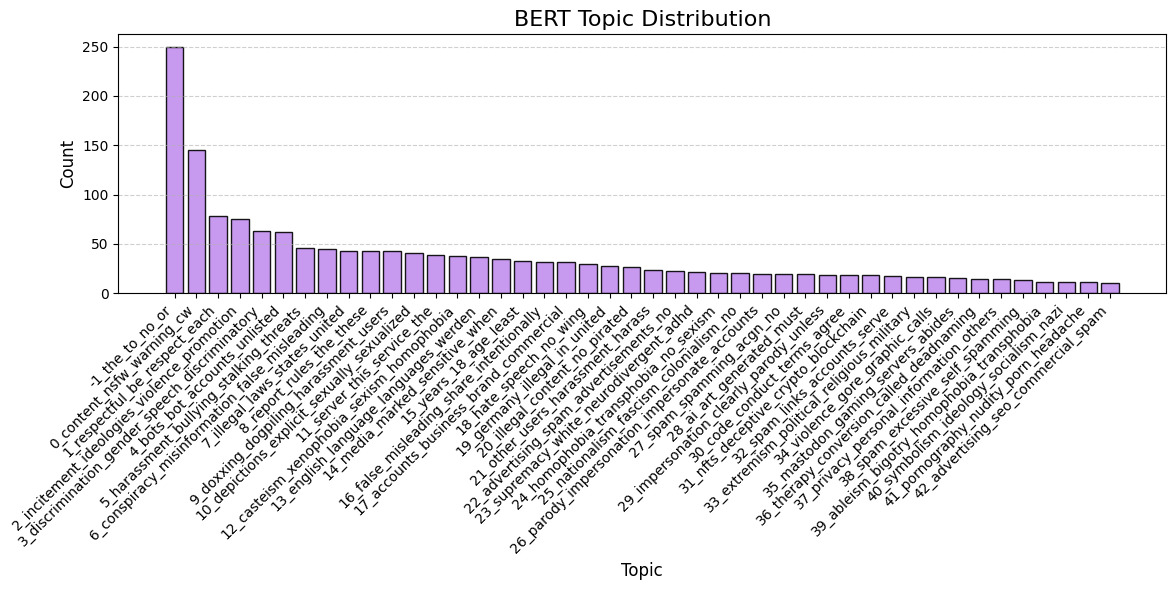

In [248]:
# topic_counts = bert_model.get_topic_info()[['Name', 'Count']]
# plt.bar(topic_counts['Name'], topic_counts['Count'])

# Get topic counts
topic_counts = bert_model.get_topic_info()[['Name', 'Count']]

# Plot settings
plt.figure(figsize=(12, 6))
bars = plt.bar(topic_counts['Name'], topic_counts['Count'], color="#C28FEE", edgecolor="black", alpha=0.9)

# Titles and labels
plt.title("BERT Topic Distribution", fontsize=16)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Count", fontsize=12)

# Rotate x-tick labels
plt.xticks(rotation=45, ha='right')

# Grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Tighter layout to fit x-tick labels
plt.tight_layout()

plt.show()


In [249]:
mastodon_rules_documents["Topic"] = topics
mastodon_rules_documents = mastodon_rules_documents.merge(
    bert_model.get_topic_info(),
    on="Topic",
    how="left"
)
mastodon_rules_documents = mastodon_rules_documents.rename(columns={"Name" : "Topic Name", 
                                                                    "Count" : "Topic Count",
                                                                    "Representation" : "Topic Representation"
                                                                    })
mastodon_rules_documents

,server_id,rule_id,text,hint,document,Topic,Topic Count,Topic Name,Topic Representation,Representative_Docs
0,0,1,Sexually explicit or violent media must be mar...,This includes content that is particularly pro...,sexually explicit or violent media must be mar...,0,145,0_content_nsfw_warning_cw,"[content, nsfw, warning, cw, warnings, sensiti...",[no explicit nsfw content without content warn...
1,0,2,"No racism, sexism, homophobia, transphobia, ab...",Transphobic behavior such as intentional misge...,no racism sexism homophobia transphobia ableis...,36,14,36_therapy_conversion_called_deadnaming,"[therapy, conversion, called, deadnaming, misg...",[no targeted misgendering deadnaming or promot...
2,0,3,No incitement of violence or promotion of viol...,Calling for people or groups to be assassinate...,no incitement of violence or promotion of viol...,2,75,2_incitement_ideologies_violence_promotion,"[incitement, ideologies, violence, promotion, ...",[no incitement of violence or promotion of vio...
3,0,4,"No harassment, block evasion, dogpiling, or do...",Repeat attempts to communicate with users who ...,no harassment block evasion dogpiling or doxxi...,21,24,21_other_users_harassment_harass,"[other, users, harassment, harass, has, contac...",[rule 3 stalking and harassment respect other ...
4,0,7,Do not share information widely-known to be fa...,False and misleading information and links fro...,do not share information widely known to be fa...,16,32,16_false_misleading_share_intentionally,"[false, misleading, share, intentionally, info...",[do not share intentionally false or misleadin...
...,...,...,...,...,...,...,...,...,...,...
1629,329,76,② 简答 ACGN 的含义？/ What does ACGN stand for?,,acgn what does acgn stand for,27,19,27_spam_spamming_acgn_no,"[spam, spamming, acgn, no, 4chan, broad, irrel...","[no spam, no spam, no spam]"
1630,329,77,③ 同意呜呜站的社区规则？/ Do you agree with the community...,,do you agree with the community rules of this ...,8,43,8_report_rules_the_these,"[report, rules, the, these, team, moderation, ...",[if you see a violation of these rules report ...
1631,329,78,🌸 缺项或错误将被拒绝 ... / Incomplete or nonsensical re...,,incomplete or nonsensical responses will resul...,-1,250,-1_the_to_no_or,"[the, to, no, or, not, don, your, in, illegal,...",[rule 6 no spam or advertising spam and advert...
1632,329,79,"详细社区规则见： / For detailed community rules, pleas...",,for detailed community rules please see,8,43,8_report_rules_the_these,"[report, rules, the, these, team, moderation, ...",[if you see a violation of these rules report ...


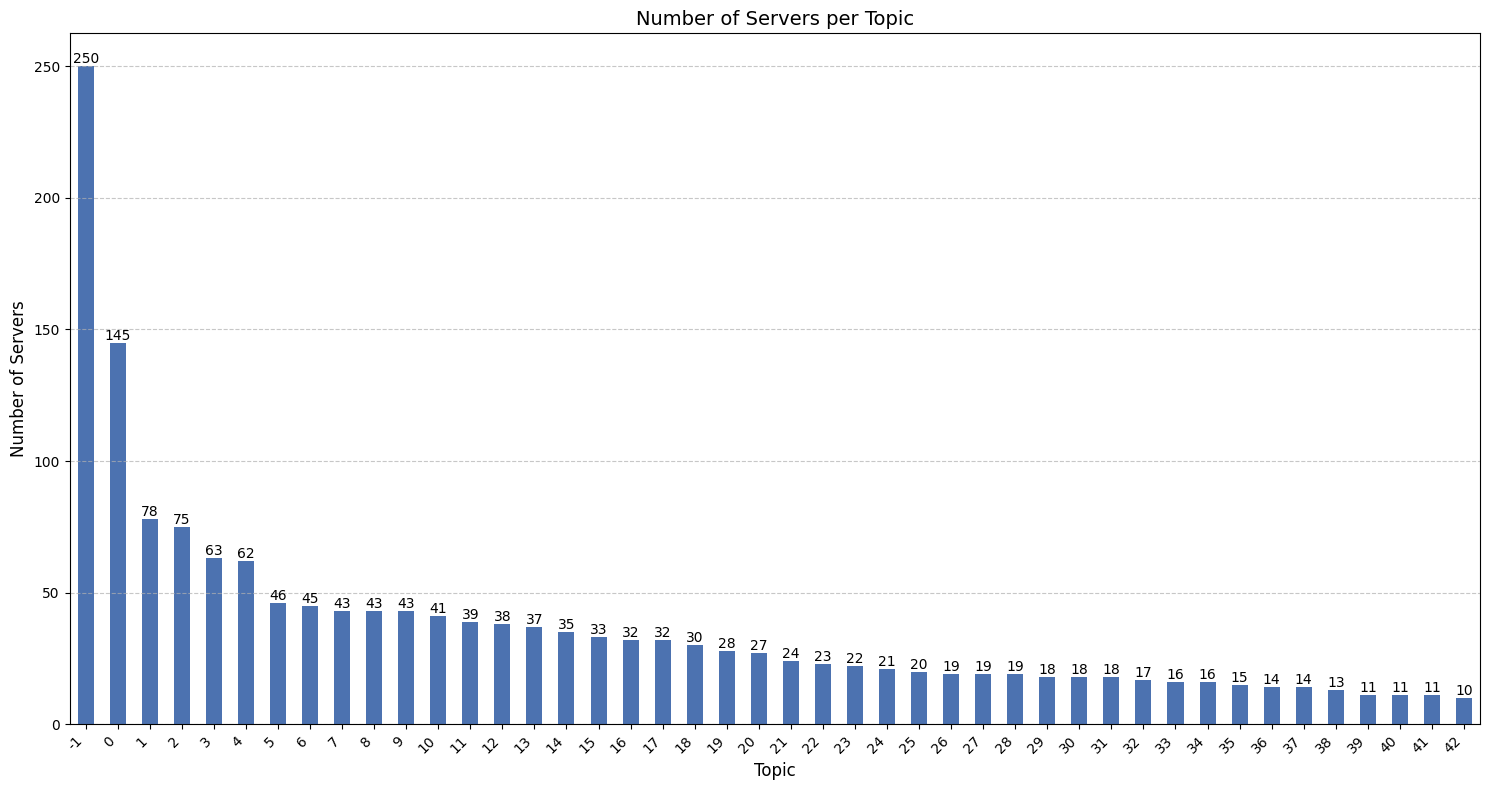


Top 5 most common topics:
Topic
-1    250
 0    145
 1     78
 2     75
 3     63
dtype: int64


In [250]:
# Create a server-topic count dataframe
server_topic_counts = mastodon_rules_documents.groupby('server_id')['Topic'].value_counts().unstack(fill_value=0)

# Plot settings
plt.figure(figsize=(15, 8))

# Create stacked bar chart
server_topic_counts.sum().plot(kind='bar', color='#4C72B0')

# Customize plot
plt.title('Number of Servers per Topic', fontsize=14)
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Number of Servers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(server_topic_counts.sum()):
    plt.text(i, v, str(int(v)), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTop 5 most common topics:")
sorted_counts = server_topic_counts.sum().sort_values(ascending=False)
print(sorted_counts.head())

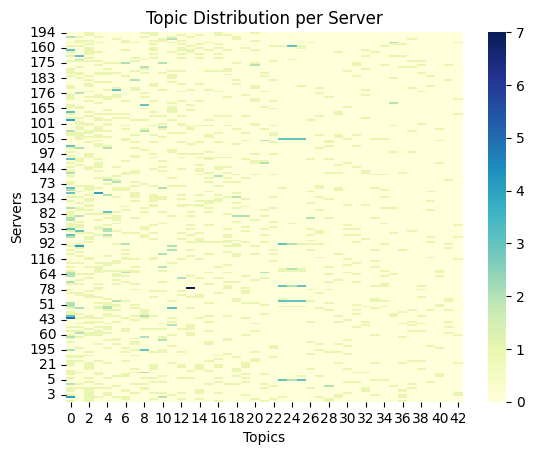

In [251]:
# Example: server_topic_counts is a DataFrame like:
#           topic_0  topic_1  topic_2  ...  topic_22
# server_A       10        2        0
# server_B        0        8        5
# ...
server_topic_counts = mastodon_rules_documents[mastodon_rules_documents["Topic"] != -1].copy()
server_topic_counts = server_topic_counts.groupby(["server_id", "Topic"]).size().unstack(fill_value=0)

user_monthly_activity = mastodon.df_en[["server_id", "total_users"]].copy()
server_topic_counts = server_topic_counts.merge(user_monthly_activity, on="server_id", how="left")

server_topic_counts = server_topic_counts.sort_values("total_users")

sns.heatmap(server_topic_counts.drop(columns = ["server_id","total_users"]), cmap="YlGnBu", annot=False)
plt.xlabel("Topics")
plt.xticks()
plt.ylabel("Servers")
plt.title("Topic Distribution per Server")
plt.show()
# order by active user per month

In [252]:
server_topic_counts

,server_id,0,1,2,3,4,5,6,7,8,...,34,35,36,37,38,39,40,41,42,total_users
194,327,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,17
191,320,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,24
190,317,2,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,42
192,321,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,43
186,309,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,12,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,83099
3,3,1,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,183608
4,4,4,0,1,1,0,1,1,0,0,...,0,0,1,0,0,0,0,0,0,191710
1,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,260323


In [108]:
lexicon = pd.read_json("utils/strictness_lexicon.json")
strict_words = np.array(lexicon["strict"].iloc[0])
strict_words

array(['no', 'never', 'not allowed', 'do not', 'don t', 'must',
       'must not', 'shall not', 'cannot', 'banned', 'ban', 'banning',
       'forbidden', 'is forbidden', 'prohibited', 'zero tolerance',
       'strictly', 'absolutely', 'will result in', 'will be removed',
       'will be banned', 'account suspension', 'subject to ban',
       'is grounds for', 'permanent ban', 'immediate removal', 'enforced',
       'illegal', 'against the law', 'against our policy', 'violation',
       'terms of service', 'code of conduct'], dtype='<U18')

In [253]:
# strictness

def compute_strictness(text):
    """ Computes the strictness score of a rule based on the modal words it contains.
    The metric is defined as follows:
        S = number of strict words that the rule contains
        L = number of lenient words that the rule contains
        T = S + T
                            
        Strictness score = 0 if T = 0
                            S / T otherwise
        
        Strictness score is between 0 and 1, equal to 0 if no imperative words are present, 
        and equal to one if all the imperative words that the rule contains are strict words."""
    lexicon = pd.read_json("utils/strictness_lexicon.json")
    def S(text):
        strict_words = np.array(lexicon["strict"].iloc[0])
        
        count_instances = np.array([text.count(word) for word in strict_words])
        return count_instances.sum()
    def L(text):
        lenient_words = np.array(lexicon["lenient"].iloc[0])
        count_instances = np.array([text.count(word) for word in lenient_words])
        return count_instances.sum()
    s, l = S(text), L(text)
    t = s + l
    return s / t if t != 0 else 0

# TODO: ask victor if better to generate lexicon based on the dataset or more generally

In [254]:
mastodon_rules_documents["strictness"] = mastodon_rules_documents["document"].apply(compute_strictness)
mastodon_rules_documents[["server_id", "rule_id", "document", "Topic Name", "strictness"]]

,server_id,rule_id,document,Topic Name,strictness
0,0,1,sexually explicit or violent media must be mar...,0_content_nsfw_warning_cw,0.4
1,0,2,no racism sexism homophobia transphobia ableis...,36_therapy_conversion_called_deadnaming,1.0
2,0,3,no incitement of violence or promotion of viol...,2_incitement_ideologies_violence_promotion,1.0
3,0,4,no harassment block evasion dogpiling or doxxi...,21_other_users_harassment_harass,1.0
4,0,7,do not share information widely known to be fa...,16_false_misleading_share_intentionally,0.8
...,...,...,...,...,...
1629,329,76,acgn what does acgn stand for,27_spam_spamming_acgn_no,0.0
1630,329,77,do you agree with the community rules of this ...,8_report_rules_the_these,0.0
1631,329,78,incomplete or nonsensical responses will resul...,-1_the_to_no_or,1.0
1632,329,79,for detailed community rules please see,8_report_rules_the_these,0.0


In [255]:
mastodon_server_strictness = mastodon_rules_documents.groupby("server_id")["strictness"].sum().reset_index()
mastodon_server_strictness

,server_id,strictness
0,0,4.866667
1,1,7.500000
2,2,10.166667
3,3,8.238095
4,4,15.166667
...,...,...
192,320,6.500000
193,321,5.500000
194,322,11.350000
195,327,4.000000


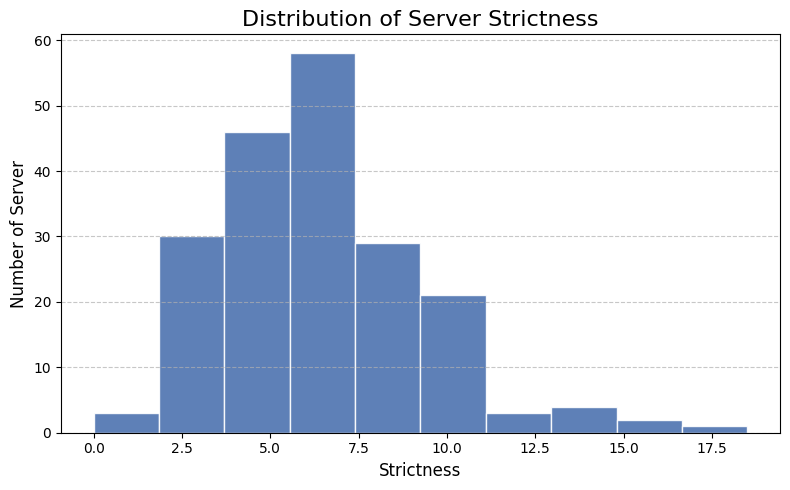

In [256]:
# Plot settings
plt.figure(figsize=(8, 5))
plt.hist(mastodon_server_strictness["strictness"], bins=10, color="#4C72B0", edgecolor="white", alpha=0.9)

# Titles and labels
plt.title("Distribution of Server Strictness", fontsize=16)
plt.xlabel("Strictness", fontsize=12)
#plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Number of Server", fontsize=12)

# Grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tighter layout
plt.tight_layout()

plt.show()


In [257]:
mastodon_server_strictness = mastodon_server_strictness.merge(df_mastodon_en,
                                                              how = "left",
                                                              on="server_id")

In [258]:
mastodon_server_strictness

,server_id,strictness,domain,title,description,active_month,languages,rules,total_users
0,0,4.866667,mastodon.social,Mastodon,The original server operated by the Mastodon g...,327503,[en],"[{'id': '1', 'text': 'Sexually explicit or vio...",2711879
1,1,7.500000,mstdn.social,Mastodon 🐘,A general-purpose Mastodon server with a 500 c...,14546,[en],"[{'id': '2', 'text': 'Sexually explicit or vio...",260323
2,2,10.166667,infosec.exchange,Infosec Exchange,A Mastodon instance for info/cyber security-mi...,13319,[en],"[{'id': '1', 'text': 'Do unto others as you th...",75725
3,3,8.238095,mas.to,mas.to,"Hello! mas.to is a fast, up-to-date and fun Ma...",11889,[en],"[{'id': '9', 'text': 'No discrimination, inclu...",183608
4,4,15.166667,mastodon.world,Mastodon,Generic Mastodon server for anyone to use.,9472,[en],"[{'id': '16', 'text': 'No illegal content, e.g...",191710
...,...,...,...,...,...,...,...,...,...
192,320,6.500000,mastodon.vanlife.is,Vanlife.is,This is a Mastodon server mainly meant for tho...,10,[en],"[{'id': '1', 'text': 'Sexually explicit or vio...",24
193,321,5.500000,darticulate.com,Mastodon for Dartisans,"A Mastodon instance for Dartisans, run by myse...",10,[en],"[{'id': '2', 'text': 'This server is intended ...",43
194,322,11.350000,dariox.club,DARiOX,A safe space for tech-centered LGBTQI+ folks a...,9,[en],"[{'id': '2', 'text': 'No illegal content', 'hi...",150
195,327,4.000000,jaxbeach.social,JaxBeach Social,Local server based in Jacksonville Beach Flori...,3,[en],"[{'id': '1', 'text': 'No Illegal content', 'hi...",17


In [259]:
# Export the results to a CSV file
export_to_csv = True
if export_to_csv:
    print("\nExporting mastodon server strictness to 'mastodon_server_strictness.csv'...")
    mastodon_server_strictness.to_csv('mastodon_server_strictness.csv', index=False)


Exporting mastodon server strictness to 'mastodon_server_strictness.csv'...


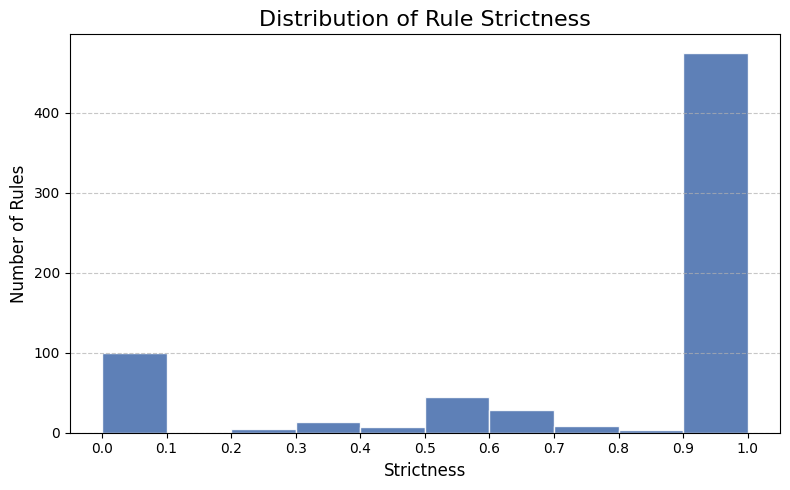

In [123]:
#mastodon_rules_documents[["rule_id", "strictness"]].plot.hist()

# Plot settings
plt.figure(figsize=(8, 5))
plt.hist(mastodon_rules_documents["strictness"], bins=10, color="#4C72B0", edgecolor="white", alpha=0.9)

# Titles and labels
plt.title("Distribution of Rule Strictness", fontsize=16)
plt.xlabel("Strictness", fontsize=12)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Number of Rules", fontsize=12)

# Grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tighter layout
plt.tight_layout()

plt.show()


#### One document = all rules from one server

In [260]:
mastodon_rules_documents

,server_id,rule_id,text,hint,document,Topic,Topic Count,Topic Name,Topic Representation,Representative_Docs,strictness
0,0,1,Sexually explicit or violent media must be mar...,This includes content that is particularly pro...,sexually explicit or violent media must be mar...,0,145,0_content_nsfw_warning_cw,"[content, nsfw, warning, cw, warnings, sensiti...",[no explicit nsfw content without content warn...,0.4
1,0,2,"No racism, sexism, homophobia, transphobia, ab...",Transphobic behavior such as intentional misge...,no racism sexism homophobia transphobia ableis...,36,14,36_therapy_conversion_called_deadnaming,"[therapy, conversion, called, deadnaming, misg...",[no targeted misgendering deadnaming or promot...,1.0
2,0,3,No incitement of violence or promotion of viol...,Calling for people or groups to be assassinate...,no incitement of violence or promotion of viol...,2,75,2_incitement_ideologies_violence_promotion,"[incitement, ideologies, violence, promotion, ...",[no incitement of violence or promotion of vio...,1.0
3,0,4,"No harassment, block evasion, dogpiling, or do...",Repeat attempts to communicate with users who ...,no harassment block evasion dogpiling or doxxi...,21,24,21_other_users_harassment_harass,"[other, users, harassment, harass, has, contac...",[rule 3 stalking and harassment respect other ...,1.0
4,0,7,Do not share information widely-known to be fa...,False and misleading information and links fro...,do not share information widely known to be fa...,16,32,16_false_misleading_share_intentionally,"[false, misleading, share, intentionally, info...",[do not share intentionally false or misleadin...,0.8
...,...,...,...,...,...,...,...,...,...,...,...
1629,329,76,② 简答 ACGN 的含义？/ What does ACGN stand for?,,acgn what does acgn stand for,27,19,27_spam_spamming_acgn_no,"[spam, spamming, acgn, no, 4chan, broad, irrel...","[no spam, no spam, no spam]",0.0
1630,329,77,③ 同意呜呜站的社区规则？/ Do you agree with the community...,,do you agree with the community rules of this ...,8,43,8_report_rules_the_these,"[report, rules, the, these, team, moderation, ...",[if you see a violation of these rules report ...,0.0
1631,329,78,🌸 缺项或错误将被拒绝 ... / Incomplete or nonsensical re...,,incomplete or nonsensical responses will resul...,-1,250,-1_the_to_no_or,"[the, to, no, or, not, don, your, in, illegal,...",[rule 6 no spam or advertising spam and advert...,1.0
1632,329,79,"详细社区规则见： / For detailed community rules, pleas...",,for detailed community rules please see,8,43,8_report_rules_the_these,"[report, rules, the, these, team, moderation, ...",[if you see a violation of these rules report ...,0.0


In [261]:
mastodon_server_rules_documents = mastodon_rules_documents.copy()
mastodon_server_rules_documents = mastodon_server_rules_documents[["server_id", "document", "Topic"]].rename(columns={"Topic":"rule_topic"})
mastodon_server_rules_documents = mastodon_server_rules_documents.groupby("server_id").agg({
    "document": lambda x: ' '.join(x),
    "rule_topic": lambda x: list(x)
}).reset_index()
mastodon_server_rules_documents

,server_id,document,rule_topic
0,0,sexually explicit or violent media must be mar...,"[0, 36, 2, 21, 16, 28]"
1,1,sexually explicit or violent media must be mar...,"[14, 22, 12, 2, 9, 20, 6, 28]"
2,2,do unto others as you think they would want do...,"[1, 0, -1, -1, 32, 3, -1, 8, 26, 37, -1, 21, 4..."
3,3,no discrimination including but not limited to...,"[36, 0, 11, 19, 2, 33, 42, 29, 4]"
4,4,no illegal content e g child pornography solic...,"[-1, -1, 6, 10, 10, 0, 23, 0, 0, -1, 27, 5, 2,..."
...,...,...,...
192,320,sexually explicit or violent media must be mar...,"[14, 12, 2, 9, 16, -1, 17]"
193,321,this server is intended to be a place for dart...,"[11, 37, 5, 18, 11, 10]"
194,322,no illegal content no false or misleading cont...,"[20, 6, 9, 2, 12, 0, 0, 0, -1, 15, 17, 32, 13,..."
195,327,no illegal content no incitement of violence o...,"[20, 2, 9, 16, 8]"


In [262]:
# Custom CountVectorizer with stop word removal
vectorizer_model = CountVectorizer(
    stop_words="english",        # Removes English stop words
    lowercase=True,              # Ensures all text is lowercased
    max_df=0.95,                 # Ignore words in >95% of docs (very common ones)
    min_df=2,                    # Ignore words in <2 docs (very rare ones)
)

# UMAP and HDBSCAN models
umap_model = UMAP(n_neighbors=4, n_components=4, min_dist=0.0)
hdbscan_model = HDBSCAN(min_cluster_size=4, min_samples=1)

# BERTopic with custom vectorizer
bert_model_server = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    seed_topic_list=seed
)

# Fit model
topics, probs = bert_model_server.fit_transform(mastodon_server_rules_documents["document"])

# Reduce to 10 topics
bert_model_server.reduce_topics(mastodon_server_rules_documents["document"], nr_topics=10)
bert_model_server.get_topic_info()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,17,-1_don_hate_18_racism,"[don, hate, 18, racism, permitted, sexual, mak...",[do using welcoming and inclusive language bei...
1,0,116,0_promotion_violent_post_racism,"[promotion, violent, post, racism, transphobia...",[sexually explicit or violent media must be ma...
2,1,14,1_allowed_rules_admins_bot,"[allowed, rules, admins, bot, don, bots, servi...",[you must read the rules you must describe you...
3,2,12,2_agree_germany_ideology_symbolism,"[agree, germany, ideology, symbolism, promotin...",[i am at least 16 years of age or older on the...
4,3,10,3_laws_work_images_break,"[laws, work, images, break, explicit, privacy,...",[no illegal content no false or misleading con...
5,4,8,4_germany_deleted_languages_european,"[germany, deleted, languages, european, langua...",[no discrimination including but not limited t...
6,5,7,5_stand_try_guideline_gaming,"[stand, try, guideline, gaming, games, people,...",[be respectful of one another no discriminatio...
7,6,5,6_respect_16_tone_mark,"[respect, 16, tone, mark, privacy, refrain, la...",[be welcoming be kind look out for each other ...
8,7,4,7_link_sensitive_business_brand,"[link, sensitive, business, brand, themed, law...",[by signing up and using the service at opalst...
9,8,4,8_talk_useful_related_increase,"[talk, useful, related, increase, mastodon, co...",[have fun and be respectful posts on pnw zone ...


### Clustering on server description

In [265]:
from transformers.pipelines import pipeline
lang_recognition = pipeline("text-classification", model="spolivin/lang-recogn-model")


def detect_english(text):
    try:
        
        return lang_recognition(text)[0]["label"] == 'English'
    except:
        return False 

Device set to use mps:0


In [266]:
mastodon_serv_descr = mastodon.df_en[["server_id", "description"]].copy()
mastodon_serv_descr[mastodon.df_en["description"].apply(detect_english)]

,server_id,description
0,0,The original server operated by the Mastodon g...
1,1,A general-purpose Mastodon server with a 500 c...
2,2,A Mastodon instance for info/cyber security-mi...
3,3,"Hello! mas.to is a fast, up-to-date and fun Ma..."
4,4,Generic Mastodon server for anyone to use.
...,...,...
317,317,Ceilidh.Online is meant to be a safe gathering...
320,320,This is a Mastodon server mainly meant for tho...
321,321,"A Mastodon instance for Dartisans, run by myse..."
322,322,A safe space for tech-centered LGBTQI+ folks a...


In [268]:
mastodon_serv_descr = mastodon.df_en[["server_id", "description"]].copy()
mastodon_serv_descr = mastodon_serv_descr[mastodon.df_en["description"].apply(detect_english)]

def _remove_empty(x):
        if isinstance(x, list) and len(x) > 0:
            return [item for item in x if item != '']
        return x

mastodon_serv_descr["description"] = mastodon_serv_descr["description"].apply(lambda x: x.strip() if isinstance(x, str) else x)
mastodon_serv_descr["description"] = mastodon_serv_descr["description"].str.lower()
mastodon_serv_descr["description"] = mastodon_serv_descr["description"].str.replace(r"[^a-zA-Z0-9\s]", " ", regex=True)
mastodon_serv_descr["description"] = mastodon_serv_descr["description"].str.replace(r"\s+", " ", regex=True).str.strip()
mastodon_serv_descr["description"] = mastodon_serv_descr["description"].str.split(" ")
mastodon_serv_descr["description"] = mastodon_serv_descr["description"].apply(_remove_empty)
mastodon_serv_descr["description"] = mastodon_serv_descr["description"].apply(lambda words: [word for word in words if word not in stop_words] if isinstance(words, list) else words)
mastodon_serv_descr["description"] = mastodon_serv_descr["description"].apply(lambda words: [word for word in words if word not in stop_words] if isinstance(words, list) else words)
mastodon_serv_descr["description"] = mastodon_serv_descr["description"].apply(lambda x: ' '.join(x))
mastodon_serv_descr

,server_id,description
0,0,original server operated mastodon ggmbh non pr...
1,1,general purpose mastodon server 500 character ...
2,2,mastodon instance info cyber security minded p...
3,3,hello mas fast date fun mastodon server
4,4,generic mastodon server anyone use
...,...,...
317,317,ceilidh online meant safe gathering place like...
320,320,mastodon server mainly meant living curious li...
321,321,mastodon instance dartisans run steve hamblett...
322,322,safe space tech centered lgbtqi folks furries ...


In [ ]:
# manually add some stop words?

In [269]:
umap_model = UMAP(n_neighbors=5, n_components=2, min_dist=0.0, transform_seed=seed, random_state=seed)
hdbscan_model = HDBSCAN(min_cluster_size=4, min_samples=1)

topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, seed_topic_list=seed)#, calculate_probabilities=True)
topics, probs = topic_model.fit_transform(mastodon_serv_descr['description'])

# Reduce to desired number of topics
#topic_model.reduce_topics(mastodon_serv_descr['description'], nr_topics=10)
topic_model.get_topic_info()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,18,-1_fpl_dedicated_friends_1000,"[fpl, dedicated, friends, 1000, know, transit,...",[mastodon instance hosted new zealand made kiw...
1,0,22,0_games_gaming_video_fandom,"[games, gaming, video, fandom, community, fan,...",[raphus social better bird site safe inclusive...
2,1,16,1_mastodon_instance_africans_run,"[mastodon, instance, africans, run, vermonters...",[small regional mastodon instance dc maryland ...
3,2,14,2_safe_lgbtqia_furry_lgbtq,"[safe, lgbtqia, furry, lgbtq, offer, allies, s...",[hachyderm safe space lgbtqia blm primarily co...
4,3,11,3_library_live_jersey_lives,"[library, live, jersey, lives, francisco, cove...",[anyone values kindness inclusivity named live...
5,4,11,4_music_trek_fans_forever,"[music, trek, fans, forever, podcast, greatest...",[server music enthusiasts concerts festivals n...
6,5,8,5_server_use_area_small,"[server, use, area, small, mastodon, residents...",[small independent mastodon server focused ser...
7,6,8,6_danish_cloud_denmark_living,"[danish, cloud, denmark, living, unofficial, k...",[mastodon server hosted copenhagen denmark dan...
8,7,7,7_infosec_science_researchers_data,"[infosec, science, researchers, data, cyberpun...",[community researchers practitioners human cen...
9,8,6,8_free_social_media_scientists,"[free, social, media, scientists, ad, platform...",[hometech social friendly home fediverse thing...


In [270]:
mastodon_serv_descr["Topic"] = topics
mastodon_serv_descr = mastodon_serv_descr.merge(
    topic_model.get_topic_info(),
    on="Topic",
    how="left"
)

mastodon_serv_descr = mastodon_serv_descr.rename(columns={"Name" : "Topic Name", 
                                                                    "Count" : "Topic Count",
                                                                    "Representation" : "Topic Representation"
                                                                    })
mastodon_serv_descr

,server_id,description,Topic,Topic Count,Topic Name,Topic Representation,Representative_Docs
0,0,original server operated mastodon ggmbh non pr...,5,8,5_server_use_area_small,"[server, use, area, small, mastodon, residents...",[small independent mastodon server focused ser...
1,1,general purpose mastodon server 500 character ...,12,5,12_languages_php_programming_language,"[languages, php, programming, language, us, pu...",[community driven server operated diverse grou...
2,2,mastodon instance info cyber security minded p...,21,4,21_hacker_addressing_democracy_click,"[hacker, addressing, democracy, click, code, t...",[mastodon community information journalism ple...
3,3,hello mas fast date fun mastodon server,15,5,15_clojure_fast_content_server,"[clojure, fast, content, server, wholesome, po...",[clojure community fediverse accounts server m...
4,4,generic mastodon server anyone use,5,8,5_server_use_area_small,"[server, use, area, small, mastodon, residents...",[small independent mastodon server focused ser...
...,...,...,...,...,...,...,...
179,317,ceilidh online meant safe gathering place like...,2,14,2_safe_lgbtqia_furry_lgbtq,"[safe, lgbtqia, furry, lgbtq, offer, allies, s...",[hachyderm safe space lgbtqia blm primarily co...
180,320,mastodon server mainly meant living curious li...,6,8,6_danish_cloud_denmark_living,"[danish, cloud, denmark, living, unofficial, k...",[mastodon server hosted copenhagen denmark dan...
181,321,mastodon instance dartisans run steve hamblett...,14,5,14_related_beloved_hex_dart,"[related, beloved, hex, dart, dev, steve, coun...",[jvm technologies related mastodon server goal...
182,322,safe space tech centered lgbtqi folks furries ...,2,14,2_safe_lgbtqia_furry_lgbtq,"[safe, lgbtqia, furry, lgbtq, offer, allies, s...",[hachyderm safe space lgbtqia blm primarily co...


In [271]:
lgbtq_safe_servers = mastodon_serv_descr[mastodon_serv_descr["Topic"] == 2]
lgbtq_safe_servers = lgbtq_safe_servers.merge(mastodon.df_en, on="server_id", how="left")
lgbtq_safe_servers = lgbtq_safe_servers.drop(columns="description_y").rename(columns={"description_x": "description"})
lgbtq_safe_servers

,server_id,description,Topic,Topic Count,Topic Name,Topic Representation,Representative_Docs,domain,title,active_month,languages,rules,total_users
0,6,hachyderm safe space lgbtqia blm primarily com...,2,14,2_safe_lgbtqia_furry_lgbtq,"[safe, lgbtqia, furry, lgbtq, offer, allies, s...",[hachyderm safe space lgbtqia blm primarily co...,hachyderm.io,Hachyderm.io,8937,[en],"[{'id': '1', 'text': 'Don't be a dick.', 'hint...",56318
1,85,furry focused instance critters like bark lgbt...,2,14,2_safe_lgbtqia_furry_lgbtq,"[safe, lgbtqia, furry, lgbtq, offer, allies, s...",[hachyderm safe space lgbtqia blm primarily co...,bark.lgbt,Bark!,546,[en],"[{'id': '1', 'text': 'No discrimination, bigot...",6377
2,93,instance aimed techies engineers types within ...,2,14,2_safe_lgbtqia_furry_lgbtq,"[safe, lgbtqia, furry, lgbtq, offer, allies, s...",[hachyderm safe space lgbtqia blm primarily co...,furry.engineer,"Furry.Engineer - Duct tape, hotfixes, and poor...",488,[en],"[{'id': '14', 'text': 'Rule #1 – Illegal Conte...",1730
3,100,qaf queer folk sincerely invites lgbtqia commu...,2,14,2_safe_lgbtqia_furry_lgbtq,"[safe, lgbtqia, furry, lgbtq, offer, allies, s...",[hachyderm safe space lgbtqia blm primarily co...,qaf.men,Queer as Folk,420,[en],"[{'id': '1', 'text': 'No racism, homophobia et...",1661
4,128,instance aimed within furry fandom though anyo...,2,14,2_safe_lgbtqia_furry_lgbtq,"[safe, lgbtqia, furry, lgbtq, offer, allies, s...",[hachyderm safe space lgbtqia blm primarily co...,pawb.fun,"Pawb.Fun - Pawbs, beans, and all things fluffy",291,[en],"[{'id': '8', 'text': 'Rule #1 – Illegal Conten...",1753
5,130,cute server lgbtqia ppl want caring safe envir...,2,14,2_safe_lgbtqia_furry_lgbtq,"[safe, lgbtqia, furry, lgbtq, offer, allies, s...",[hachyderm safe space lgbtqia blm primarily co...,lgbtqia.space,LGBTQIA.Space,285,[en],"[{'id': '9', 'text': 'No Content that is illeg...",1545
6,135,server intended safe place lgbtqia individuals...,2,14,2_safe_lgbtqia_furry_lgbtq,"[safe, lgbtqia, furry, lgbtq, offer, allies, s...",[hachyderm safe space lgbtqia blm primarily co...,gaygeek.social,Gaygeek Social,267,[en],"[{'id': '1', 'text': 'Don't post anything whic...",2016
7,143,queer tech furry instance open anyone fits atm...,2,14,2_safe_lgbtqia_furry_lgbtq,"[safe, lgbtqia, furry, lgbtq, offer, allies, s...",[hachyderm safe space lgbtqia blm primarily co...,woof.tech,Woof.tech (Mastodon),246,[en],"[{'id': '1', 'text': 'Do not partake in unlawf...",717
8,156,place people chronically ill mentally ill disa...,2,14,2_safe_lgbtqia_furry_lgbtq,"[safe, lgbtqia, furry, lgbtq, offer, allies, s...",[hachyderm safe space lgbtqia blm primarily co...,disabled.social,disabled.social,217,[en],"[{'id': '12', 'text': 'I am at least 16 years ...",2937
9,167,another server furry community special feature...,2,14,2_safe_lgbtqia_furry_lgbtq,"[safe, lgbtqia, furry, lgbtq, offer, allies, s...",[hachyderm safe space lgbtqia blm primarily co...,furries.club,Furries.club,164,[en],"[{'id': '1', 'text': 'Discrimination of any ki...",790


In [272]:
export_lgbt = True
if export_lgbt:
    print("\nExporting LGBTQ+ safe servers to 'lgbtq_safe_servers.csv'...")
    lgbtq_safe_servers.to_csv('lgbtq_safe_servers.csv', index=False)
    print("Exported successfully.")


Exporting LGBTQ+ safe servers to 'lgbtq_safe_servers.csv'...
Exported successfully.


In [135]:
#cluster_on_topic(mastodon_serv_descr, topic_model_descr)

### Heat map?

In [47]:
# heat map of the topics from rules and topics from description

## Reddit dataset

In [291]:
df_reddit_en

,domain,title,description,languages,total_users,active_month,rules,server_id
0,Home,Home,nan,en,307843,51,[],0
2,NoStupidQuestions,No such thing as stupid questions,Ask away!\n\nDisclaimer: This is an anonymous ...,en,6021303,4872,[Top level comments must contain a genuine hum...,2
3,BaldursGate3,Baldur's Gate 3,"A community all about Baldur's Gate III, the r...",en,3118378,1384,"[Be civil to one another., Respect the opinio...",3
4,facepalm,now double verified,/r/facepalm - please sir can I have some more?,en,8145733,2345,"[No uncivil, bigoted, misogynist, misandrist, ...",4
5,interestingasfuck,Interesting As Fuck,For anything truly interesting as fuck,en,13961838,4038,"[Posts MUST be INTERESTING AS FUCK!, No Polit...",5
...,...,...,...,...,...,...,...,...
95,SteamDeck,Steam Deck,The Unofficial Subreddit for the Valve Steam D...,en,903284,446,"[Be Kind Or Get Banned, Posts must be about o...",95
96,college,College,The subreddit for discussion related to colleg...,en,2911405,76,"[Do not post spam or surveys., Do not post an...",96
97,manga,"/r/manga: manga, on reddit.",Everything and anything manga! (manhwa/manhua...,en,4725267,1480,"[Disrespectful, Follow submission guidelines ...",97
98,CrazyFuckingVideos,CrazyFuckingVideos,Crazy fucking videos for your viewing pleasure,en,2240152,799,"[Follow Reddit's TOS, Be civil, Must be a Cr...",98


In [292]:
reddit.df

,domain,title,description,languages,total_users,active_month,rules,server_id
0,Home,Home,nan,en,307843,51,[],0
1,AskReddit,Ask Reddit...,r/AskReddit is the place to ask and answer tho...,es,54701432,9986,[Rule 1 - Questions must be clear and direct a...,1
2,NoStupidQuestions,No such thing as stupid questions,Ask away!\n\nDisclaimer: This is an anonymous ...,en,6021303,4872,[Top level comments must contain a genuine hum...,2
3,BaldursGate3,Baldur's Gate 3,"A community all about Baldur's Gate III, the r...",en,3118378,1384,"[Be civil to one another., Respect the opinio...",3
4,facepalm,now double verified,/r/facepalm - please sir can I have some more?,en,8145733,2345,"[No uncivil, bigoted, misogynist, misandrist, ...",4
...,...,...,...,...,...,...,...,...
95,SteamDeck,Steam Deck,The Unofficial Subreddit for the Valve Steam D...,en,903284,446,"[Be Kind Or Get Banned, Posts must be about o...",95
96,college,College,The subreddit for discussion related to colleg...,en,2911405,76,"[Do not post spam or surveys., Do not post an...",96
97,manga,"/r/manga: manga, on reddit.",Everything and anything manga! (manhwa/manhua...,en,4725267,1480,"[Disrespectful, Follow submission guidelines ...",97
98,CrazyFuckingVideos,CrazyFuckingVideos,Crazy fucking videos for your viewing pleasure,en,2240152,799,"[Follow Reddit's TOS, Be civil, Must be a Cr...",98


In [293]:
reddit_rules = reddit.extract_rules()
reddit_rules

,server_id,rule_id,rules
0,1,0,Rule 1 - Questions must be clear and direct an...
1,1,1,Rule 2 - No personal or professional advice r...
2,1,2,Rule 3 - Open ended questions only
3,1,3,Rule 4 - No personal info
4,1,4,Rule 5 - No loaded questions
...,...,...,...
1050,99,8,No image macros/memes
1051,99,9,No crossposts
1052,99,10,No r/RoastMe
1053,99,11,Moderators Discretion


In [294]:
reddit.predicts_english_rules()

,server_id,rule_id,rules,is_english_pred
0,1,0,Rule 1 - Questions must be clear and direct an...,True
1,1,1,Rule 2 - No personal or professional advice r...,True
2,1,2,Rule 3 - Open ended questions only,True
3,1,3,Rule 4 - No personal info,True
4,1,4,Rule 5 - No loaded questions,True
...,...,...,...,...
1050,99,8,No image macros/memes,True
1051,99,9,No crossposts,True
1052,99,10,No r/RoastMe,False
1053,99,11,Moderators Discretion,False


In [295]:
gla = reddit.rules_df.groupby("server_id")[["server_id", "is_english_pred"]].apply(lambda server: server["is_english_pred"].sum() / server["server_id"].count()).reset_index(name='is_english_pred_rate')

gla[gla["is_english_pred_rate"] != 1]

,server_id,is_english_pred_rate
2,3,0.933333
3,4,0.700000
4,5,0.750000
5,6,0.750000
6,7,0.600000
...,...,...
92,93,0.428571
93,94,0.666667
96,97,0.600000
97,98,0.818182


In [296]:
reddit_rules = reddit.rules_df.copy()
reddit_rules["strictness"] = reddit_rules["rules"].apply(compute_strictness)
reddit_rules[["server_id", "rule_id", "strictness"]]

,server_id,rule_id,strictness
0,1,0,0.666667
1,1,1,0.000000
2,1,2,0.000000
3,1,3,0.000000
4,1,4,0.000000
...,...,...,...
1050,99,8,0.000000
1051,99,9,0.000000
1052,99,10,0.000000
1053,99,11,0.000000


In [297]:
reddit_server_strictness = reddit_rules.groupby("server_id")["strictness"].sum().reset_index()
reddit_server_strictness

,server_id,strictness
0,1,0.666667
1,2,2.000000
2,3,3.000000
3,4,0.000000
4,5,1.000000
...,...,...
94,95,4.000000
95,96,12.000000
96,97,0.000000
97,98,1.000000


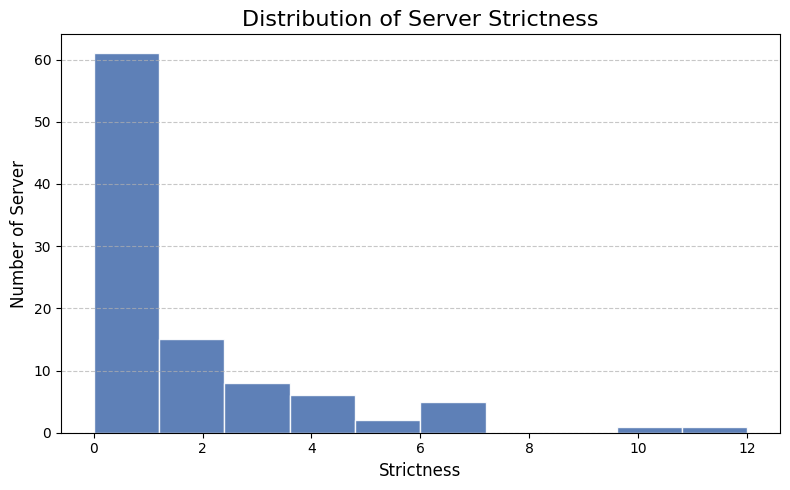

In [298]:
# Plot settings
plt.figure(figsize=(8, 5))
plt.hist(reddit_server_strictness["strictness"], bins=10, color="#4C72B0", edgecolor="white", alpha=0.9)

# Titles and labels
plt.title("Distribution of Server Strictness", fontsize=16)
plt.xlabel("Strictness", fontsize=12)
#plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Number of Server", fontsize=12)

# Grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Tighter layout
plt.tight_layout()

plt.show()


In [299]:
df_reddit_en

,domain,title,description,languages,total_users,active_month,rules,server_id
0,Home,Home,nan,en,307843,51,[],0
2,NoStupidQuestions,No such thing as stupid questions,Ask away!\n\nDisclaimer: This is an anonymous ...,en,6021303,4872,[Top level comments must contain a genuine hum...,2
3,BaldursGate3,Baldur's Gate 3,"A community all about Baldur's Gate III, the r...",en,3118378,1384,"[Be civil to one another., Respect the opinio...",3
4,facepalm,now double verified,/r/facepalm - please sir can I have some more?,en,8145733,2345,"[No uncivil, bigoted, misogynist, misandrist, ...",4
5,interestingasfuck,Interesting As Fuck,For anything truly interesting as fuck,en,13961838,4038,"[Posts MUST be INTERESTING AS FUCK!, No Polit...",5
...,...,...,...,...,...,...,...,...
95,SteamDeck,Steam Deck,The Unofficial Subreddit for the Valve Steam D...,en,903284,446,"[Be Kind Or Get Banned, Posts must be about o...",95
96,college,College,The subreddit for discussion related to colleg...,en,2911405,76,"[Do not post spam or surveys., Do not post an...",96
97,manga,"/r/manga: manga, on reddit.",Everything and anything manga! (manhwa/manhua...,en,4725267,1480,"[Disrespectful, Follow submission guidelines ...",97
98,CrazyFuckingVideos,CrazyFuckingVideos,Crazy fucking videos for your viewing pleasure,en,2240152,799,"[Follow Reddit's TOS, Be civil, Must be a Cr...",98


In [300]:
reddit_server_strictness = reddit_server_strictness.merge(reddit.df,
                                                              how = "left",
                                                              on="server_id")

In [301]:
reddit_server_strictness

,server_id,strictness,domain,title,description,languages,total_users,active_month,rules
0,1,0.666667,AskReddit,Ask Reddit...,r/AskReddit is the place to ask and answer tho...,es,54701432,9986,[Rule 1 - Questions must be clear and direct a...
1,2,2.000000,NoStupidQuestions,No such thing as stupid questions,Ask away!\n\nDisclaimer: This is an anonymous ...,en,6021303,4872,[Top level comments must contain a genuine hum...
2,3,3.000000,BaldursGate3,Baldur's Gate 3,"A community all about Baldur's Gate III, the r...",en,3118378,1384,"[Be civil to one another., Respect the opinio..."
3,4,0.000000,facepalm,now double verified,/r/facepalm - please sir can I have some more?,en,8145733,2345,"[No uncivil, bigoted, misogynist, misandrist, ..."
4,5,1.000000,interestingasfuck,Interesting As Fuck,For anything truly interesting as fuck,en,13961838,4038,"[Posts MUST be INTERESTING AS FUCK!, No Polit..."
...,...,...,...,...,...,...,...,...,...
94,95,4.000000,SteamDeck,Steam Deck,The Unofficial Subreddit for the Valve Steam D...,en,903284,446,"[Be Kind Or Get Banned, Posts must be about o..."
95,96,12.000000,college,College,The subreddit for discussion related to colleg...,en,2911405,76,"[Do not post spam or surveys., Do not post an..."
96,97,0.000000,manga,"/r/manga: manga, on reddit.",Everything and anything manga! (manhwa/manhua...,en,4725267,1480,"[Disrespectful, Follow submission guidelines ..."
97,98,1.000000,CrazyFuckingVideos,CrazyFuckingVideos,Crazy fucking videos for your viewing pleasure,en,2240152,799,"[Follow Reddit's TOS, Be civil, Must be a Cr..."


In [ ]:
# Export the results to a CSV file
export_to_csv = False
if export_to_csv:
    print("\nExporting reddit server strictness to 'reddit_server_strictness.csv'...")
    reddit_server_strictness.to_csv('reddit_server_strictness.csv', index=False)


Exporting reddit server strictness to 'reddit_server_strictness.csv'...


# Old part of reddit vvvvvvvvvv

In [50]:
rules = df_reddit_en['rules'].explode().reset_index(drop=False)
rules = rules.rename(columns={"index": "server_id"})
# We add an index to the rules
rules["rule_id"] = rules.groupby("server_id").cumcount()
rules = rules.dropna()
rules

,server_id,rules,rule_id
1,2,Top level comments must contain a genuine huma...,0
2,2,Please try searching the subreddit for your q...,1
3,2,Be Nice,2
4,2,No medical advice questions,3
5,2,No trolling or joke questions,4
...,...,...,...
1040,99,No image macros/memes,8
1041,99,No crossposts,9
1042,99,No r/RoastMe,10
1043,99,Moderators Discretion,11


In [51]:
# remove rules that are not written in english
df_english = rules[rules.rules.apply(utils.is_english)].reset_index(drop=True)

non_english_rules_pourcentage = 100 * (rules.shape[0] - df_english.shape[0]) / rules.shape[0]

print(f" We removed {rules.shape[0] - df_english.shape[0]} of the {rules.shape[0]} rules ({non_english_rules_pourcentage:.0f}%) that were not detected to be in english.")

AttributeError: module 'utils.utils' has no attribute 'is_english'

In [ ]:
def r_remove_empty(x):
    if isinstance(x, list) and len(x) > 0:
        return [item for item in x if item != '']
    return x

def r_standardize_text(df_column):
    df_column = df_column.apply(lambda x: x.strip() if isinstance(x, str) else x)
    df_column = df_column.str.lower()
    df_column = df_column.str.replace(r"[^a-zA-Z0-9\s]", " ", regex=True)
    df_column = df_column.str.replace(r"\s+", " ", regex=True).str.strip()
    df_column = df_column.str.split(" ")
    df_column = df_column.apply(r_remove_empty)
    return df_column

In [ ]:
type(df_english)

pandas.core.frame.DataFrame

In [ ]:
df_english

,server_id,rules,rule_id
0,2,Top level comments must contain a genuine huma...,0
1,2,Please try searching the subreddit for your q...,1
2,2,No suicide or 'was I raped/sexual assaulted/s...,5
3,2,"No self-promotion, shilling or begging",6
4,2,No illegal/unethical or disturbing subject ma...,7
...,...,...,...
762,99,No personal information,4
763,99,No long videos (>10s) or long texts,7
764,99,No r/RoastMe,10
765,99,Moderators Discretion,11


In [ ]:
# Process te rules for NLP
standardized_df = df_english.copy()
standardized_df["rules"] = r_standardize_text(standardized_df['rules'])

# Compute strictness metrics TODO: define metrics and compute them
#standardized_df["strict_rule"] = standardized_df["rules"].apply(utils.contains_strict_words)
standardized_df #["rules"]

,server_id,rules,rule_id
0,2,"[top, level, comments, must, contain, a, genui...",0
1,2,"[please, try, searching, the, subreddit, for, ...",1
2,2,"[no, suicide, or, was, i, raped, sexual, assau...",5
3,2,"[no, self, promotion, shilling, or, begging]",6
4,2,"[no, illegal, unethical, or, disturbing, subje...",7
...,...,...,...
762,99,"[no, personal, information]",4
763,99,"[no, long, videos, 10s, or, long, texts]",7
764,99,"[no, r, roastme]",10
765,99,"[moderators, discretion]",11


In [ ]:
# Keep only the rows from standardized_df that have a matching server_id and rule_id in df_english
standardized_df = standardized_df.merge(df_english[["server_id", "rule_id"]], on=["server_id", "rule_id"], how='inner')
standardized_df

,server_id,rules,rule_id
0,2,"[top, level, comments, must, contain, a, genui...",0
1,2,"[please, try, searching, the, subreddit, for, ...",1
2,2,"[no, suicide, or, was, i, raped, sexual, assau...",5
3,2,"[no, self, promotion, shilling, or, begging]",6
4,2,"[no, illegal, unethical, or, disturbing, subje...",7
...,...,...,...
762,99,"[no, personal, information]",4
763,99,"[no, long, videos, 10s, or, long, texts]",7
764,99,"[no, r, roastme]",10
765,99,"[moderators, discretion]",11


In [ ]:
# Natural language processing

# Download stopwords if not already done
nltk.download('stopwords')

# Set of English stopwords
stop_words = set(stopwords.words('english')).union(set(stopwords.words('french'))).union(set(stopwords.words('german'))).union(set(stopwords.words('spanish')))

# Remove stop words from the tokenized lists
standardized_df["rules"] = standardized_df["rules"].apply(lambda words: [word for word in words if word not in stop_words] if isinstance(words, list) else words)

# Lemmatize tokens
# No need to lemmatize for berTOPIC
#standardized_df["text"] = standardized_df["text"].apply(lemmatize)
#standardized_df["hint"] = standardized_df["hint"].apply(lemmatize)

standardized_df

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eglantinevialaneix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,server_id,rules,rule_id
0,2,"[top, level, comments, must, contain, genuine,...",0
1,2,"[please, try, searching, subreddit, question, ...",1
2,2,"[suicide, raped, sexual, assaulted, sexually, ...",5
3,2,"[self, promotion, shilling, begging]",6
4,2,"[illegal, unethical, disturbing, subject, matter]",7
...,...,...,...
762,99,"[personal, information]",4
763,99,"[long, videos, 10s, long, texts]",7
764,99,"[r, roastme]",10
765,99,"[moderators, discretion]",11


In [ ]:
#tokenize each text and each hint
nlp_df = standardized_df.copy()

#nlp_df["document"] = nlp_df.apply(create_document, axis=1)

vocab = nlp_df["rules"].explode().unique()
nlp_df["rules"].explode().value_counts()

rules
posts         126
must           73
content        64
post           39
self           35
             ... 
grey            1
keys            1
reviews         1
deals           1
moderators      1
Name: count, Length: 1171, dtype: int64

In [ ]:
# TF-IDF scores
# Join the tokens back into strings
nlp_df['document_str'] = nlp_df['rules'].apply(lambda x: ' '.join(x))

# Create and fit TF-IDF Vectorizer
tfidf_vect = TfidfVectorizer()
tfidf_matrix = tfidf_vect.fit_transform(nlp_df['document_str'])

# Get feature names (words)
feature_names = tfidf_vect.get_feature_names_out()

tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
    

TF-IDF matrix shape: (767, 1157)


In [ ]:
# Display top terms with highest average TF-IDF scores
mean_tfidf = tfidf_matrix.mean(axis=0).A1
term_scores = pd.DataFrame({'term': feature_names, 'score': mean_tfidf})
print("Top 10 terms by average TF-IDF score:")
print(term_scores.sort_values('score', ascending=False).head(10))

Top 10 terms by average TF-IDF score:
          term     score
778      posts  0.041990
230    content  0.027015
677       must  0.025548
912       self  0.020700
798  promotion  0.017493
607        low  0.017454
189      civil  0.016888
775       post  0.015915
341     effort  0.014231
768   politics  0.013817


In [ ]:
# Display the top TF-IDF words for a few sample documents
sample_indices = np.random.choice(tfidf.index, size=5, replace=False)
for idx in sample_indices:
    print(f"Top TF-IDF words for document {idx}:")
    doc_tfidf = tfidf.iloc[idx]
    top_words = doc_tfidf.nlargest(5)
    print(top_words, '\n')

Top TF-IDF words for document 722:
accessory    0.400045
modding      0.400045
setup        0.400045
hardware     0.360151
review       0.360151
Name: 722, dtype: float64 

Top TF-IDF words for document 583:
tumblr         0.637504
posts          0.517937
screenshots    0.481146
must           0.306315
10k            0.000000
Name: 583, dtype: float64 

Top TF-IDF words for document 361:
generated      0.509268
user           0.509268
advertising    0.452856
surveys        0.443270
content        0.282358
Name: 361, dtype: float64 

Top TF-IDF words for document 659:
high        0.540310
topical     0.540310
relevant    0.442926
quality     0.383681
content     0.269695
Name: 659, dtype: float64 

Top TF-IDF words for document 104:
third    0.693675
party    0.648727
posts    0.313000
10k      0.000000
10s      0.000000
Name: 104, dtype: float64 



In [ ]:
# Topic modeling
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(nlp_df['document_str'])

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,164,-1_must_english_questions_posts,"[must, english, questions, posts, submissions,...","[top level comment must answer ask follow, pos..."
1,0,112,0_personal_witch_bigotry_harassment,"[personal, witch, bigotry, harassment, hunts, ...","[personal information witch hunting, comments ..."
2,1,81,1_promotion_self_giveaways_spam,"[promotion, self, giveaways, spam, surveys, ad...","[self promotion, self promotion, self promotion]"
3,2,51,2_rules_content_rule_follow,"[rules, content, rule, follow, restricted, red...","[specific restricted content see rules list, r..."
4,3,46,3_links_piracy_exploits_cheats,"[links, piracy, exploits, cheats, pirated, lin...","[direct links copyrighted material, links disc..."
5,4,37,4_posts_must_relevant_deck,"[posts, must, relevant, deck, related, steam, ...",[game review deck posts must include game titl...
6,5,33,5_screenshots_memes_meme_image,"[screenshots, memes, meme, image, pictures, te...","[screenshots, screenshots memes infographics, ..."
7,6,31,6_discussion_thread_threads_megathread,"[discussion, thread, threads, megathread, use,...","[discussion moderation meta sub topics, use da..."
8,7,30,7_titles_title_clickbait_editorialized,"[titles, title, clickbait, editorialized, arti...","[editorialized misleading titles, title must m..."
9,8,28,8_nsfw_spoilers_gore_porn,"[nsfw, spoilers, gore, porn, mark, dick, death...","[mark nsfw content, mark nsfw spoilers, proper..."


In [ ]:
# try consensus clutering on topics shared between servers

In [ ]:
# topic modelling on description of mastodon, reddit and mast+reddit

# Clustering on server description

In [176]:
reddit_serv_descr = reddit.df_en[["server_id", "description"]].copy()
reddit_serv_descr = reddit_serv_descr[reddit_serv_descr["description"] != 'nan']

reddit_serv_descr

,server_id,description
2,2,Ask away!\n\nDisclaimer: This is an anonymous ...
3,3,"A community all about Baldur's Gate III, the r..."
4,4,/r/facepalm - please sir can I have some more?
5,5,For anything truly interesting as fuck
6,6,For the most interesting things on the internet
...,...,...
95,95,The Unofficial Subreddit for the Valve Steam D...
96,96,The subreddit for discussion related to colleg...
97,97,Everything and anything manga! (manhwa/manhua...
98,98,Crazy fucking videos for your viewing pleasure


In [177]:
# keep only english servers
#english_servers = english_servers[english_servers != 93] # we remove server 93 since its descr is not in english
#mastodon_serv_descr = mastodon_serv_descr[mastodon_serv_descr["server_id"].isin(english_servers)]

def _remove_empty(x):
        if isinstance(x, list) and len(x) > 0:
            return [item for item in x if item != '']
        return x

reddit_serv_descr["description"] = reddit_serv_descr["description"].apply(lambda x: x.strip() if isinstance(x, str) else x)
reddit_serv_descr["description"] = reddit_serv_descr["description"].str.lower()
reddit_serv_descr["description"] = reddit_serv_descr["description"].str.replace(r"[^a-zA-Z0-9\s]", " ", regex=True)
reddit_serv_descr["description"] = reddit_serv_descr["description"].str.replace(r"\s+", " ", regex=True).str.strip()
reddit_serv_descr["description"] = reddit_serv_descr["description"].str.split(" ")
reddit_serv_descr["description"] = reddit_serv_descr["description"].apply(_remove_empty)
reddit_serv_descr["description"] = reddit_serv_descr["description"].apply(lambda words: [word for word in words if word not in stop_words] if isinstance(words, list) else words)
reddit_serv_descr["description"] = reddit_serv_descr["description"].apply(lambda words: [word for word in words if word not in stop_words] if isinstance(words, list) else words)
reddit_serv_descr["description"] = reddit_serv_descr["description"].apply(lambda x: ' '.join(x))
reddit_serv_descr

,server_id,description
2,2,ask away disclaimer anonymous forum answers ma...
3,3,community baldur gate iii role playing video g...
4,4,r facepalm please sir
5,5,anything truly interesting fuck
6,6,interesting things internet
...,...,...
95,95,unofficial subreddit valve steam deck find dis...
96,96,subreddit discussion related college collegiat...
97,97,everything anything manga manhwa manhua okay d...
98,98,crazy fucking videos viewing pleasure


In [187]:
# #using model fitted on mastodon:
# # Fit on Mastodon descriptions
# umap_model = UMAP(n_neighbors=5, n_components=2, min_dist=0.0, transform_seed=seed, random_state=seed)
# hdbscan_model = HDBSCAN(min_cluster_size=4, min_samples=1, prediction_data=True)

# topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, seed_topic_list=seed, calculate_probabilities=True)
# topics_mastodon, probs_mastodon = topic_model.fit_transform(mastodon_serv_descr['description'])

# # Do NOT reduce topics yet
# topic_info = topic_model.get_topic_info()

# # Now transform the Reddit data
# topics_reddit, probs_reddit = topic_model.transform(reddit_serv_descr['description'])


In [188]:
umap_model = UMAP(n_neighbors=5, n_components=2, min_dist=0.0, transform_seed=seed, random_state=seed)
hdbscan_model = HDBSCAN(min_cluster_size=4, min_samples=1)

topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, seed_topic_list=seed)
topics, probs = topic_model.fit_transform(reddit_serv_descr['description'])

# Reduce to desired number of topics
#topic_model.reduce_topics(mastodon_serv_descr['description'], nr_topics=10)
topic_model.get_topic_info()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,7,-1_minecraft_roommates_bad_java,"[minecraft, roommates, bad, java, edition, dis...",[serious gossips great sense humor bores bulli...
1,0,10,0_elden_ring_rpg_community,"[elden, ring, rpg, community, game, gate, bald...",[official community genshin impact latest open...
2,1,9,1_youtube_rules_normal_us,"[youtube, rules, normal, us, give, information...",[community like r amitheasshole except unlike ...
3,2,9,2_news_place_politics_discuss,"[news, place, politics, discuss, find, dedicat...",[place news articles current events united sta...
4,3,8,3_videos_images_best_find,"[videos, images, best, find, worst, high, exac...","[crazy fucking videos viewing pleasure, place ..."
5,4,8,4_work_want_reference_help,"[work, want, reference, help, tools, happened,...",[happened people ask reddit advice help take r...
6,5,7,5_discord_steam_reddit_help,"[discord, steam, reddit, help, use, due, party...",[subreddit members steam community fans steam ...
7,6,7,6_interesting_mildly_learn_stuff,"[interesting, mildly, learn, stuff, something,...","[interesting things internet, learn something ..."
8,7,7,7_strike_counter_goal_gaming,"[strike, counter, goal, gaming, discussion, su...",[goal r games provide place informative intere...
9,8,7,8_overwatch_history_helldivers_future,"[overwatch, history, helldivers, future, fanta...",[subreddit dedicated various iterations dungeo...


In [192]:
reddit_serv_descr["M_or_R"] = "Reddit"
mastodon_serv_descr["M_or_R"] = "Mastodon"
platforms_serv_descr = pd.concat([mastodon_serv_descr[["server_id", "description", "M_or_R"]], reddit_serv_descr])
platforms_serv_descr

,server_id,description,M_or_R
0,0,original server operated mastodon ggmbh non pr...,Mastodon
1,1,general purpose mastodon server 500 character ...,Mastodon
2,2,mastodon instance info cyber security minded p...,Mastodon
3,3,hello mas fast date fun mastodon server,Mastodon
4,5,hachyderm safe space lgbtqia blm primarily com...,Mastodon
...,...,...,...
95,95,unofficial subreddit valve steam deck find dis...,Reddit
96,96,subreddit discussion related college collegiat...,Reddit
97,97,everything anything manga manhwa manhua okay d...,Reddit
98,98,crazy fucking videos viewing pleasure,Reddit


In [193]:
umap_model = UMAP(n_neighbors=5, n_components=2, min_dist=0.0, transform_seed=seed, random_state=seed)
hdbscan_model = HDBSCAN(min_cluster_size=4, min_samples=1)

topic_model = BERTopic(umap_model=umap_model, hdbscan_model=hdbscan_model, seed_topic_list=seed)#, calculate_probabilities=True)
topics, probs = topic_model.fit_transform(platforms_serv_descr['description'])

# Reduce to desired number of topics
#topic_model.reduce_topics(mastodon_serv_descr['description'], nr_topics=10)
topic_model.get_topic_info()


,Topic,Count,Name,Representation,Representative_Docs
0,-1,3,-1_youtube_com_rules_https,"[youtube, com, rules, https, camp, answer, eur...",[camp smolnet org mastodon instance smol inter...
1,0,12,0_news_discussion_goal_place,"[news, discussion, goal, place, discussions, q...",[place major news around world excluding us in...
2,1,11,1_identify_scotland_live_intended,"[identify, scotland, live, intended, people, f...",[anyone values kindness inclusivity named live...
3,2,9,2_mastodon_instance_africans_vermonters,"[mastodon, instance, africans, vermonters, sou...",[mastodon instance focusing hiking mountaineer...
4,3,9,3_interesting_reference_something_guides,"[interesting, reference, something, guides, mi...",[learn something new every day learn today sub...
5,4,9,4_pc_gaming_welcome_source,"[pc, gaming, welcome, source, pcmr, deck, hard...",[unofficial subreddit valve steam deck find di...
6,5,8,5_lgbtqia_safe_labor_union,"[lgbtqia, safe, labor, union, allies, tech, fu...",[server intended safe place lgbtqia individual...
7,6,8,6_minecraft_pals_creators_java,"[minecraft, pals, creators, java, build, aroun...",[sunny garden community indie creators draw pa...
8,7,8,7_mastodon_server_business_theatl,"[mastodon, server, business, theatl, social, p...",[theatl social mastodon server focused metro a...
9,8,8,8_us_roommates_bad_give,"[us, roommates, bad, give, find, public, unpop...",[give us tales bad roommates gross annoying ps...


In [194]:
platforms_serv_descr["Topic"] = topics
platforms_serv_descr = platforms_serv_descr.merge(
    topic_model.get_topic_info(),
    on="Topic",
    how="left"
)

platforms_serv_descr = platforms_serv_descr.rename(columns={"Name" : "Topic Name", 
                                                                    "Count" : "Topic Count",
                                                                    "Representation" : "Topic Representation"
                                                                    })
platforms_serv_descr

,server_id,description,M_or_R,Topic,Topic Count,Topic Name,Topic Representation,Representative_Docs
0,0,original server operated mastodon ggmbh non pr...,Mastodon,10,7,10_server_mastodon_fast_focused,"[server, mastodon, fast, focused, mas, hello, ...",[small independent mastodon server focused ser...
1,1,general purpose mastodon server 500 character ...,Mastodon,17,5,17_languages_singapore_english_welcome,"[languages, singapore, english, welcome, purpo...",[general purpose mastodon server languages wel...
2,2,mastodon instance info cyber security minded p...,Mastodon,20,5,20_infosec_technology_12k_defcon,"[infosec, technology, 12k, defcon, cats, cyber...",[infosec privacy technology leftward politics ...
3,3,hello mas fast date fun mastodon server,Mastodon,10,7,10_server_mastodon_fast_focused,"[server, mastodon, fast, focused, mas, hello, ...",[small independent mastodon server focused ser...
4,5,hachyderm safe space lgbtqia blm primarily com...,Mastodon,5,8,5_lgbtqia_safe_labor_union,"[lgbtqia, safe, labor, union, allies, tech, fu...",[server intended safe place lgbtqia individual...
...,...,...,...,...,...,...,...,...
172,95,unofficial subreddit valve steam deck find dis...,Reddit,4,9,4_pc_gaming_welcome_source,"[pc, gaming, welcome, source, pcmr, deck, hard...",[unofficial subreddit valve steam deck find di...
173,96,subreddit discussion related college collegiat...,Reddit,8,8,8_us_roommates_bad_give,"[us, roommates, bad, give, find, public, unpop...",[give us tales bad roommates gross annoying ps...
174,97,everything anything manga manhwa manhua okay d...,Reddit,24,4,24_anime_manga_piece_anything,"[anime, manga, piece, anything, new, series, r...",[learn budgeting saving getting debt credit in...
175,98,crazy fucking videos viewing pleasure,Reddit,16,5,16_images_quality_videos_viewing,"[images, quality, videos, viewing, photographs...","[crazy fucking videos viewing pleasure, high q..."


In [196]:
m_vs_r_count_per_topic = platforms_serv_descr.groupby(["Topic", "M_or_R"]).size().unstack(fill_value=0)
m_vs_r_count_per_topic

M_or_R,Mastodon,Reddit
Topic,,
-1,2,1
0,0,12
1,8,3
2,9,0
3,0,9
4,1,8
5,7,1
6,4,4
7,8,0


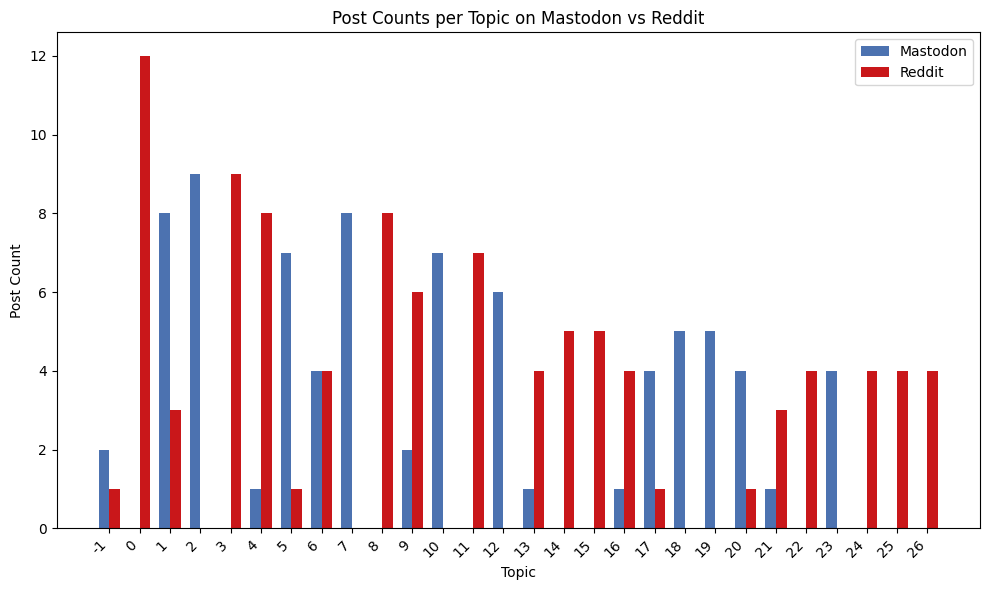

In [199]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming m_vs_r_count_per_topic is a DataFrame with index as topics
labels = m_vs_r_count_per_topic.index
x = np.arange(len(labels))  # the label locations
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, m_vs_r_count_per_topic["Mastodon"], width, label="Mastodon", color="#4C72B0")
bars2 = ax.bar(x + width/2, m_vs_r_count_per_topic["Reddit"], width, label="Reddit", color="#C9171A")

# Add labels, title, legend
ax.set_xlabel("Topic")
ax.set_ylabel("Post Count")
ax.set_title("Post Counts per Topic on Mastodon vs Reddit")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

# Optional: improve layout
plt.tight_layout()
plt.show()
